In [3]:
import matplotlib.pyplot as plt
# import tnetwork as tn
import networkx as nx
import pickle
import numpy as np
from cdlib import algorithms

MIN_YEAR = 1920
MAX_YEAR = 2021

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'bayanpy', 'infomap', 'wurlitzer', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [ ]:
# import sys
# !{sys.executable} -m pip install cdlib

  Using cached cdlib-0.4.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached demon-2.0.6-py3-none-any.whl.metadata (5.1 kB)
  Using cached python-louvain-0.16.tar.gz (204 kB)
  Preparing metadata (setup.py) ... done
  Using cached pulp-3.3.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached eva_lcd-0.1.1-py3-none-any.whl.metadata (731 bytes)
  Using cached bimlpa-0.1.2-py3-none-any.whl.metadata (725 bytes)
  Using cached python_igraph-0.11.9-py3-none-any.whl.metadata (3.1 kB)
  Using cached angelcommunity-2.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached dynetx-0.3.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached thresholdclustering-1.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached python_levenshtein-0.27.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
Using cached cdlib-0.4.0-py3-none-any.whl (263 kB)
Using cached python_igraph-0.11.9-py3-none-any.whl (9.2 kB)


In [7]:
# get the initial graph (Replace with however you want to read the network)
with open("/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Computation Theory and Mathematics.pkl", 'rb') as file:
    p = pickle.load(file)
    # print(p["cycle"].iloc[0]) 
    G = p['graph']
    # reps = p['optimized']["optimal cycle nodes"].dropna()

# nodes = list(G.nodes)

# # each row of p["cycle"] is a DataFrame describing one cycle
# reps = []
# for i, cycle_df in enumerate(p["cycle"]):
#     edges = cycle_df["simplex"].tolist()
#     concepts = set()
#     for (a, b) in edges:
#         concepts.add(nodes[a])
#         concepts.add(nodes[b])
#     reps.append(list(concepts))

reps = []

# Graph.nodes gives an ordered NodeView. Convert once.
node_list = list(G.nodes)

for cycle_df in p["cycle"]:
    cycle_nodes = set()

    # each simplex is a tuple like (i, j)
    for i, j in cycle_df["simplex"]:
        cycle_nodes.add(node_list[i])
        cycle_nodes.add(node_list[j])

    reps.append(list(cycle_nodes))

# reps is now a list of concept lists
print(len(reps), "cycles extracted")
print(reps[0][:10])

with open("/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Computation Theory and Mathematics (1).pkl", 'rb') as file:
    G = pickle.load(file)
    print(type(G))

years = np.linspace(0, 1, num=50)

print(list(G.nodes(data=True))[:3])
print(list(G.edges(data=True))[:3])
# function to get g at a given year
def G_at(y):
    G_y = nx.Graph()
    G_y.add_nodes_from([(n, d) for n, d in G.nodes(data=True) if d['norm_year'] < y])
    G_y.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True) if d['norm_year'] < y])
    return G_y

# snapshots (G at each year)
G_snapshots = [G_at(y) for y in years]

# plot formating
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(4)
ax[0].set_title('Nodes')
ax[1].set_title('Edges')
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Number of Nodes')
ax[1].set_ylabel('Number of Edges')

# plot graph attributes
ax[0].plot(years, [len(g.nodes) for g in G_snapshots])
ax[1].plot(years, [len(g.edges) for g in G_snapshots])

# finalize it
fig.tight_layout()

KeyError: 'graph'

In [3]:
dynamic_coms = algorithms.louvain(G_snapshots[-1], resolution=2)

coms = dynamic_coms.communities
node_to_com_dict = {}
for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
    for node in community:
        node_to_com_dict[node] = i
# print(node_to_com_dict)

big_rep_cycle_list1 = []
for thing in reps:
    big_rep_cycle_list1.append(list(thing))

filtered_big_reps = []
for cycle in big_rep_cycle_list1:
    present = True
    for nodething in cycle:
        if nodething not in G_snapshots[-1].nodes():
            present = False
    if present:
        filtered_big_reps.append(cycle)

import random

G = G_snapshots[-1]

def find_random_cycle(G, length, max_attempts=1000):
    nodes = list(G.nodes)
    if not nodes:
        return None

    for _ in range(max_attempts):
        start_node = random.choice(nodes)
        path = [start_node]
        visited = {start_node}

        current_node = start_node
        for _ in range(length - 1): 
            neighbors = [n for n in G.neighbors(current_node) if n not in visited]
            if not neighbors:
                break  

            next_node = random.choice(neighbors)
            path.append(next_node)
            visited.add(next_node)
            current_node = next_node

        if len(path) == length and start_node in G.neighbors(current_node):
            path.append(start_node)
            return path

    return None 


hole_lengths = []
for item in filtered_big_reps:
    hole_lengths.append(len(item))

G = G_snapshots[-1]

found_cycles = []
unique_coms = {}
hole_lengths_index = 0
for n in range(13488):
    rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
    # print(rand_cycle)
    while (not rand_cycle) or (rand_cycle in found_cycles):
        rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
    found_cycles.append(rand_cycle)
    cycle_communities = [node_to_com_dict[node] for node in rand_cycle]
    unique_communities = set(cycle_communities)
    # unique_coms.append(len(unique_communities))
    if len(rand_cycle) in unique_coms.keys():
        unique_coms[len(rand_cycle)].append(len(unique_communities))
    else:
        unique_coms[len(rand_cycle)] = [len(unique_communities)]
    hole_lengths_index+=1

coms = dynamic_coms.communities
node_to_com_dict = {}
for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
    for node in community:
        node_to_com_dict[node] = i
# print(node_to_com_dict)

big_rep_cycle_list1 = []
for thing in reps:
    big_rep_cycle_list1.append(list(thing))

filtered_big_reps = []
for cycle in big_rep_cycle_list1:
    present = True
    for nodething in cycle:
        if nodething not in G_snapshots[-1].nodes():
            present = False
    if present:
        filtered_big_reps.append(cycle)

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def expected_vals(unique_coms):
    sizes = []
    avg_coms_values = []

    for walk_length, com_list in unique_coms.items():
        avg_coms = np.mean(com_list)
        sizes.append(walk_length)
        avg_coms_values.append(avg_coms)

    sizes = np.array(sizes)
    avg_coms_values = np.array(avg_coms_values)
    slope, intercept, r_value, p_value, std_err = stats.linregress(sizes, avg_coms_values)
    
    expected_line_equation = f"y = {slope:.2f}x + {intercept:.2f}"

    return slope, intercept


topic = "Applied Math"

cycle_sizes = []
community_counts = []

for cycle in filtered_big_reps:
    communities = set(node_to_com_dict[node] for node in cycle)
    community_count = len(communities)
    cycle_sizes.append(len(cycle))
    community_counts.append(community_count)

cycle_sizes = np.array(cycle_sizes)
community_counts = np.array(community_counts)

plt.figure(figsize=(8, 6))
hb = plt.hexbin(cycle_sizes, community_counts, gridsize=10, cmap="YlGnBu", mincnt=1)
cb = plt.colorbar(hb)

plt.plot([min(cycle_sizes), max(cycle_sizes)], [min(cycle_sizes), max(cycle_sizes)], 'r--', label='Upper Bound (y=x)')

# plt.plot([min(cycle_sizes), 15], [min(cycle_sizes), 15], 'r--', label='Upper Bound (y=x)')

s, i = expected_vals(unique_coms)
expected_line = s * cycle_sizes + i
plt.plot(cycle_sizes, expected_line, 'k--', label="Random Expectation (From Random Walks)")

slope, intercept, r_value, p_value, std_err = stats.linregress(cycle_sizes, community_counts)
line_fit = slope * cycle_sizes + intercept
plt.plot(cycle_sizes, line_fit, 'k-', label=f'Linear Fit: y={slope:.2f}x + {intercept:.2f}')

ci_upper = line_fit + 1.96 * std_err
ci_lower = line_fit - 1.96 * std_err
plt.fill_between(cycle_sizes, ci_lower, ci_upper, color='gray', alpha=0.2)

plt.xlabel('cycle length') 
plt.ylabel('n. communities')
plt.title(f'{topic}, y={slope:.2f}x + {intercept:.2f}')

plt.legend()

plt.show()

NameError: name 'G_snapshots' is not defined

Filtered to 13487 cycles under length 100


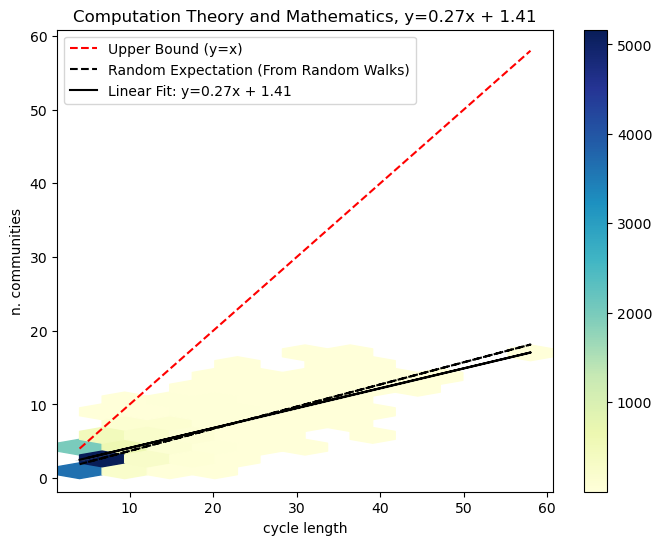

In [50]:
dynamic_coms = algorithms.louvain(G_snapshots[-1], resolution=2)

reps = [r for r in reps if len(r) < 100] 
print(f"Filtered to {len(reps)} cycles under length 100")

coms = dynamic_coms.communities
node_to_com_dict = {}
for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
    for node in community:
        node_to_com_dict[node] = i
# print(node_to_com_dict)

big_rep_cycle_list1 = []
for thing in reps:
    big_rep_cycle_list1.append(list(thing))

filtered_big_reps = []
for cycle in big_rep_cycle_list1:
    present = True
    for nodething in cycle:
        if nodething not in G_snapshots[-1].nodes():
            present = False
    if present:
        filtered_big_reps.append(cycle)

import random

G = G_snapshots[-1]

def find_random_cycle(G, length, max_attempts=1000):
    nodes = list(G.nodes)
    if not nodes:
        return None

    for _ in range(max_attempts):
        start_node = random.choice(nodes)
        path = [start_node]
        visited = {start_node}

        current_node = start_node
        for _ in range(length - 1): 
            neighbors = [n for n in G.neighbors(current_node) if n not in visited]
            if not neighbors:
                break  

            next_node = random.choice(neighbors)
            path.append(next_node)
            visited.add(next_node)
            current_node = next_node

        if len(path) == length and start_node in G.neighbors(current_node):
            path.append(start_node)
            return path

    return None 


hole_lengths = []
for item in filtered_big_reps:
    hole_lengths.append(len(item))

G = G_snapshots[-1]

found_cycles = []
unique_coms = {}
hole_lengths_index = 0
for n in range(len(reps)):
    rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
    # print(rand_cycle)
    while (not rand_cycle) or (rand_cycle in found_cycles):
        rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
    found_cycles.append(rand_cycle)
    cycle_communities = [node_to_com_dict[node] for node in rand_cycle]
    unique_communities = set(cycle_communities)
    # unique_coms.append(len(unique_communities))
    if len(rand_cycle) in unique_coms.keys():
        unique_coms[len(rand_cycle)].append(len(unique_communities))
    else:
        unique_coms[len(rand_cycle)] = [len(unique_communities)]
    hole_lengths_index+=1

coms = dynamic_coms.communities
node_to_com_dict = {}
for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
    for node in community:
        node_to_com_dict[node] = i
# print(node_to_com_dict)

big_rep_cycle_list1 = []
for thing in reps:
    big_rep_cycle_list1.append(list(thing))

filtered_big_reps = []
for cycle in big_rep_cycle_list1:
    present = True
    for nodething in cycle:
        if nodething not in G_snapshots[-1].nodes():
            present = False
    if present:
        filtered_big_reps.append(cycle)

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def expected_vals(unique_coms):
    sizes = []
    avg_coms_values = []

    for walk_length, com_list in unique_coms.items():
        avg_coms = np.mean(com_list)
        sizes.append(walk_length)
        avg_coms_values.append(avg_coms)

    sizes = np.array(sizes)
    avg_coms_values = np.array(avg_coms_values)
    slope, intercept, r_value, p_value, std_err = stats.linregress(sizes, avg_coms_values)
    
    expected_line_equation = f"y = {slope:.2f}x + {intercept:.2f}"

    return slope, intercept


topic = "Computation Theory and Mathematics"

cycle_sizes = []
community_counts = []

for cycle in filtered_big_reps:
    communities = set(node_to_com_dict[node] for node in cycle)
    community_count = len(communities)
    cycle_sizes.append(len(cycle))
    community_counts.append(community_count)

cycle_sizes = np.array(cycle_sizes)
community_counts = np.array(community_counts)

plt.figure(figsize=(8, 6))
hb = plt.hexbin(cycle_sizes, community_counts, gridsize=10, cmap="YlGnBu", mincnt=1)
cb = plt.colorbar(hb)

plt.plot([min(cycle_sizes), max(cycle_sizes)], [min(cycle_sizes), max(cycle_sizes)], 'r--', label='Upper Bound (y=x)')

# plt.plot([min(cycle_sizes), 15], [min(cycle_sizes), 15], 'r--', label='Upper Bound (y=x)')

s, i = expected_vals(unique_coms)
expected_line = s * cycle_sizes + i
plt.plot(cycle_sizes, expected_line, 'k--', label="Random Expectation (From Random Walks)")

slope, intercept, r_value, p_value, std_err = stats.linregress(cycle_sizes, community_counts)
line_fit = slope * cycle_sizes + intercept
plt.plot(cycle_sizes, line_fit, 'k-', label=f'Linear Fit: y={slope:.2f}x + {intercept:.2f}')

ci_upper = line_fit + 1.96 * std_err
ci_lower = line_fit - 1.96 * std_err
plt.fill_between(cycle_sizes, ci_lower, ci_upper, color='gray', alpha=0.2)

plt.xlabel('cycle length') 
plt.ylabel('n. communities')
plt.title(f'{topic}, y={slope:.2f}x + {intercept:.2f}')

plt.legend()

plt.show()

### Function it

In [5]:
def load_data(file_path, graph_path):
    with open(file_path, 'rb') as file:
        p = pickle.load(file)

    with open(graph_path, 'rb') as file:
        G = pickle.load(file)

    nodes = list(G.nodes)
    reps = []
    for i, cycle_df in enumerate(p["cycle"]):
        edges = cycle_df["simplex"].tolist()
        concepts = set()
        for (a, b) in edges:
            concepts.add(nodes[a])
            concepts.add(nodes[b])
        reps.append(list(concepts))

    years = np.linspace(0, 1, num=50)

    def G_at(y):
        G_y = nx.Graph()
        G_y.add_nodes_from([(n, d) for n, d in G.nodes(data=True) if d['norm_year'] < y])
        G_y.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True) if d['norm_year'] < y])
        return G_y

    G_snapshots = [G_at(y) for y in years]

    # plot formating
    # fig, ax = plt.subplots(1, 2)
    # fig.set_figwidth(8)
    # fig.set_figheight(4)
    # ax[0].set_title('Nodes')
    # ax[1].set_title('Edges')
    # ax[0].set_xlabel('Year')
    # ax[1].set_xlabel('Year')
    # ax[0].set_ylabel('Number of Nodes')
    # ax[1].set_ylabel('Number of Edges')

    # # plot graph attributes
    # ax[0].plot(years, [len(g.nodes) for g in G_snapshots])
    # ax[1].plot(years, [len(g.edges) for g in G_snapshots])

    # # finalize it
    # fig.tight_layout()

    return reps, G_snapshots

In [12]:
def process_data(reps, G_snapshots, domain_name):    
    dynamic_coms = algorithms.louvain(G_snapshots[-1], resolution=2)
    rog = len(reps)
    reps = [r for r in reps if len(r) < 100] 
    print(f"Filtered to {len(reps)} cycles under length 100 (from {rog})")

    coms = dynamic_coms.communities
    node_to_com_dict = {}
    for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
        for node in community:
            node_to_com_dict[node] = i
    # print(node_to_com_dict)

    big_rep_cycle_list1 = []
    for thing in reps:
        big_rep_cycle_list1.append(list(thing))

    filtered_big_reps = []
    for cycle in big_rep_cycle_list1:
        present = True
        for nodething in cycle:
            if nodething not in G_snapshots[-1].nodes():
                present = False
        if present:
            filtered_big_reps.append(cycle)

    import random

    G = G_snapshots[-1]

    def find_random_cycle(G, length, max_attempts=1000):
        nodes = list(G.nodes)
        if not nodes:
            return None

        for _ in range(max_attempts):
            start_node = random.choice(nodes)
            path = [start_node]
            visited = {start_node}

            current_node = start_node
            for _ in range(length - 1): 
                neighbors = [n for n in G.neighbors(current_node) if n not in visited]
                if not neighbors:
                    break  

                next_node = random.choice(neighbors)
                path.append(next_node)
                visited.add(next_node)
                current_node = next_node

            if len(path) == length and start_node in G.neighbors(current_node):
                path.append(start_node)
                return path

        return None 


    hole_lengths = []
    for item in filtered_big_reps:
        hole_lengths.append(len(item))

    G = G_snapshots[-1]

    found_cycles = []
    unique_coms = {}
    hole_lengths_index = 0
    for n in range(len(reps)-1):
        rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
        # print(rand_cycle)
        while (not rand_cycle) or (rand_cycle in found_cycles):
            rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
        found_cycles.append(rand_cycle)
        cycle_communities = [node_to_com_dict[node] for node in rand_cycle]
        unique_communities = set(cycle_communities)
        # unique_coms.append(len(unique_communities))
        if len(rand_cycle) in unique_coms.keys():
            unique_coms[len(rand_cycle)].append(len(unique_communities))
        else:
            unique_coms[len(rand_cycle)] = [len(unique_communities)]
        hole_lengths_index+=1

    coms = dynamic_coms.communities
    node_to_com_dict = {}
    for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
        for node in community:
            node_to_com_dict[node] = i
    # print(node_to_com_dict)

    big_rep_cycle_list1 = []
    for thing in reps:
        big_rep_cycle_list1.append(list(thing))

    filtered_big_reps = []
    for cycle in big_rep_cycle_list1:
        present = True
        for nodething in cycle:
            if nodething not in G_snapshots[-1].nodes():
                present = False
        if present:
            filtered_big_reps.append(cycle)

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats

    def expected_vals(unique_coms):
        sizes = []
        avg_coms_values = []

        for walk_length, com_list in unique_coms.items():
            avg_coms = np.mean(com_list)
            sizes.append(walk_length)
            avg_coms_values.append(avg_coms)

        sizes = np.array(sizes)
        avg_coms_values = np.array(avg_coms_values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(sizes, avg_coms_values)
        
        expected_line_equation = f"y = {slope:.2f}x + {intercept:.2f}"

        return slope, intercept


    topic = domain_name

    cycle_sizes = []
    community_counts = []

    for cycle in filtered_big_reps:
        communities = set(node_to_com_dict[node] for node in cycle)
        community_count = len(communities)
        cycle_sizes.append(len(cycle))
        community_counts.append(community_count)

    cycle_sizes = np.array(cycle_sizes)
    community_counts = np.array(community_counts)

    plt.figure(figsize=(8, 6))
    hb = plt.hexbin(cycle_sizes, community_counts, gridsize=10, cmap="YlGnBu", mincnt=1)
    cb = plt.colorbar(hb)

    plt.plot([min(cycle_sizes), max(cycle_sizes)], [min(cycle_sizes), max(cycle_sizes)], 'r--', label='Upper Bound (y=x)')

    # plt.plot([min(cycle_sizes), 15], [min(cycle_sizes), 15], 'r--', label='Upper Bound (y=x)')

    s, i = expected_vals(unique_coms)
    expected_line = s * cycle_sizes + i
    plt.plot(cycle_sizes, expected_line, 'b--', label="Random Expectation (From Random Walks)")

    slope, intercept, r_value, p_value, std_err = stats.linregress(cycle_sizes, community_counts)
    line_fit = slope * cycle_sizes + intercept
    plt.plot(cycle_sizes, line_fit, 'k-', label=f'Linear Fit: y={slope:.2f}x + {intercept:.2f}')

    x_min = min(cycle_sizes)
    x_max = max(cycle_sizes)

    # Use a dense grid for numerical integration
    x_grid = np.linspace(x_min, x_max, 5000)

    # Evaluate both lines on the grid
    empirical_vals = slope * x_grid + intercept
    expected_vals_grid = s * x_grid + i

    # Signed vertical difference at each x
    diff = empirical_vals - expected_vals_grid

    # Step 2: Numerical integration (trapezoidal rule)
    signed_integrated_gap = np.trapz(diff, x_grid)

    # Positive → empirical ABOVE expected
    # Negative → empirical BELOW expected

    print(f"Signed integrated gap for {topic}: {signed_integrated_gap}")

    ci_upper = line_fit + 1.96 * std_err
    ci_lower = line_fit - 1.96 * std_err
    plt.fill_between(cycle_sizes, ci_lower, ci_upper, color='gray', alpha=0.2)

    plt.xlabel('cycle length') 
    plt.ylabel('n. communities')
    plt.title(f'{topic}, y={slope:.2f}x + {intercept:.2f}')

    plt.legend()

    plt.show()

Filtered to 13487 cycles under length 100 (from 13488)
Signed integrated gap for Computation Theory and Mathematics: -42.80746273000545


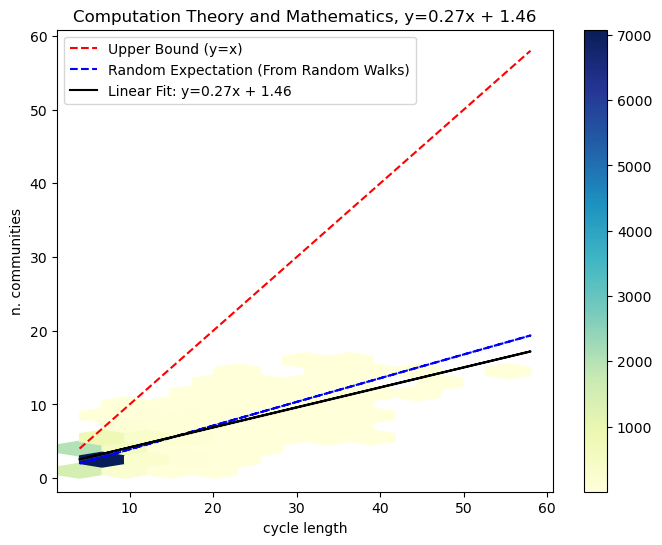

In [12]:
domain_name = "Computation Theory and Mathematics"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Computation Theory and Mathematics.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Computation Theory and Mathematics graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 10292 cycles under length 100 (from 10292)
Signed integrated gap for Quantum Physics: 198.76193345739551


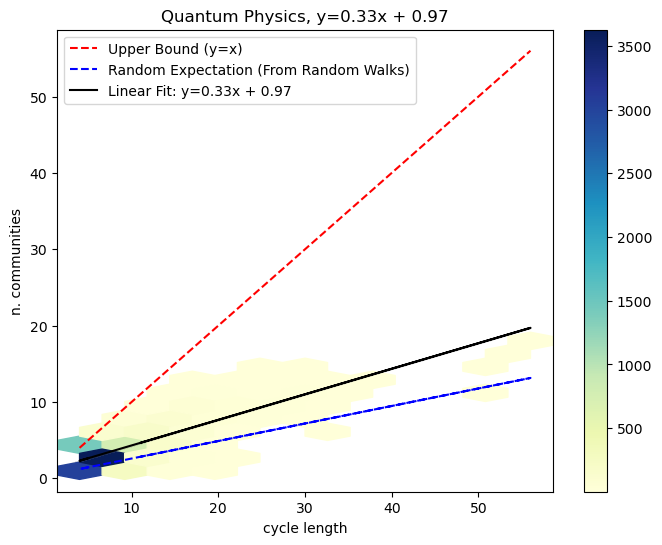

In [13]:
domain_name = "Quantum Physics"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Quantum Physics.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Quantum Physics graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 5777 cycles under length 100 (from 5777)


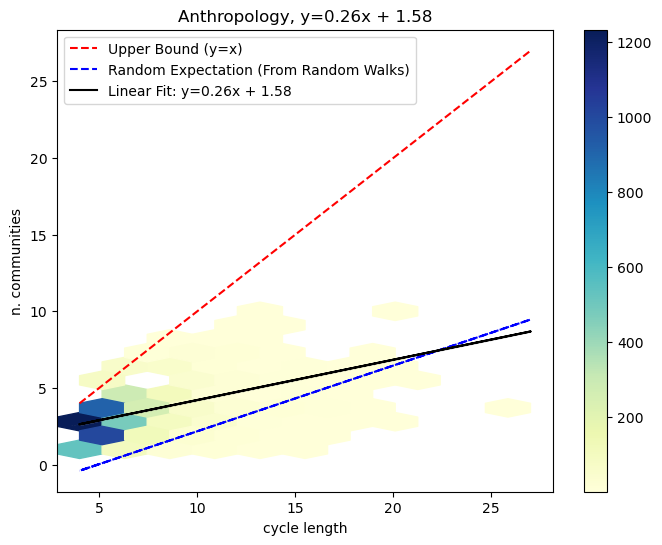

In [92]:
domain_name = "Anthropology"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Anthropology.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Anthropology graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 4753 cycles under length 100 (from 4753)


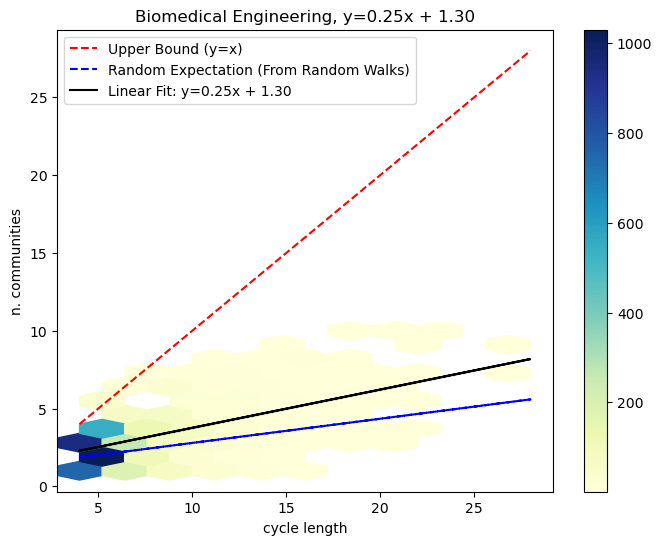

In [93]:
domain_name = "Biomedical Engineering"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Biomedical Engineering.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Biomedical Engineering graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 428 cycles under length 100 (from 428)


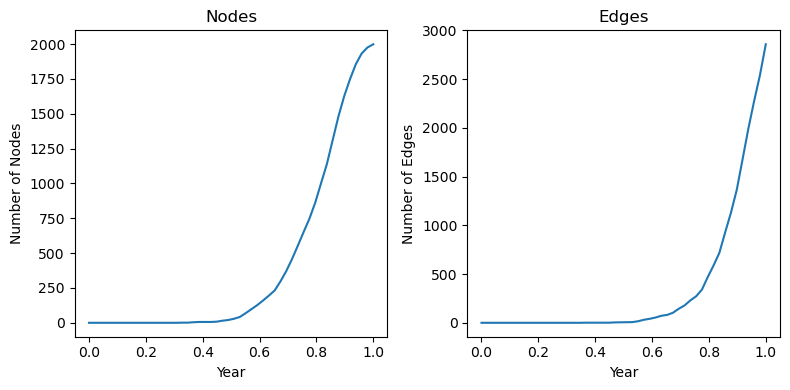

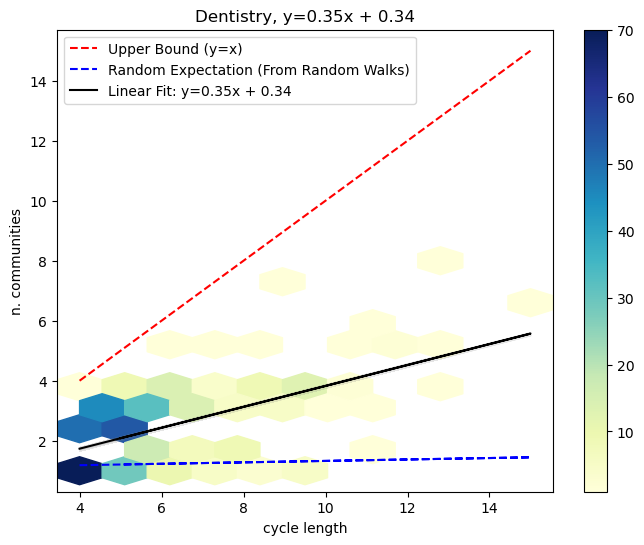

In [77]:
domain_name = "Dentistry"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Dentistry.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Dentistry graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 6617 cycles under length 100 (from 6617)


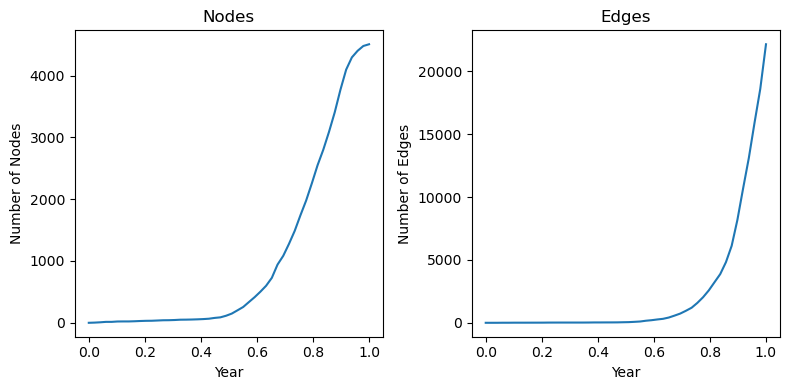

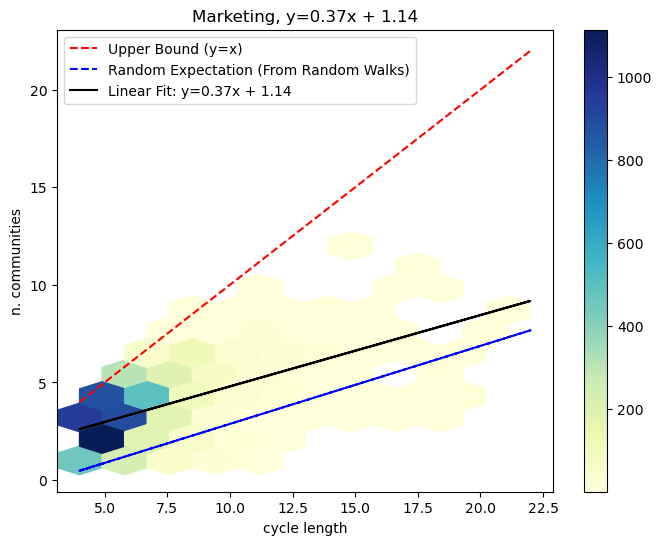

In [80]:
domain_name = "Marketing"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Marketing.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Marketing graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 5566 cycles under length 100 (from 5566)


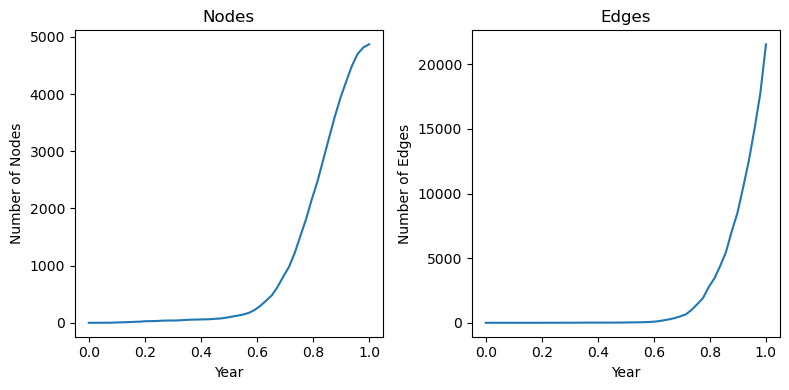

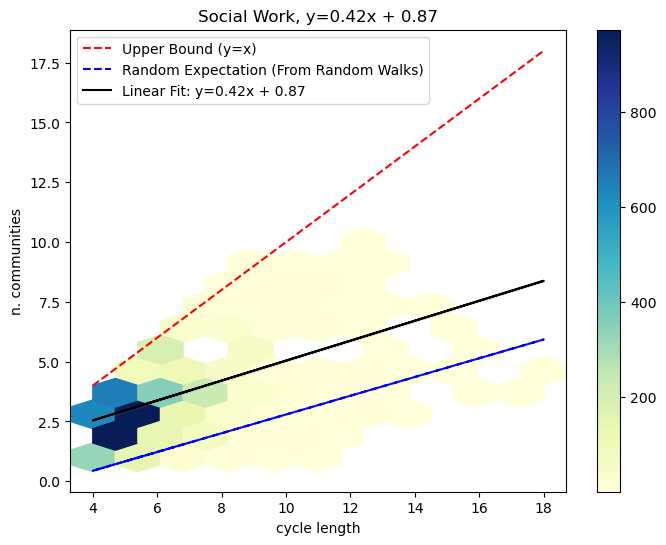

In [82]:
domain_name = "Social Work"
cycle_reps_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Social Work.pkl"
graph_path = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/Social Work graph.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Processing Oncology and Carcinogenesis...
Filtered to 3943 cycles under length 100 (from 3943)


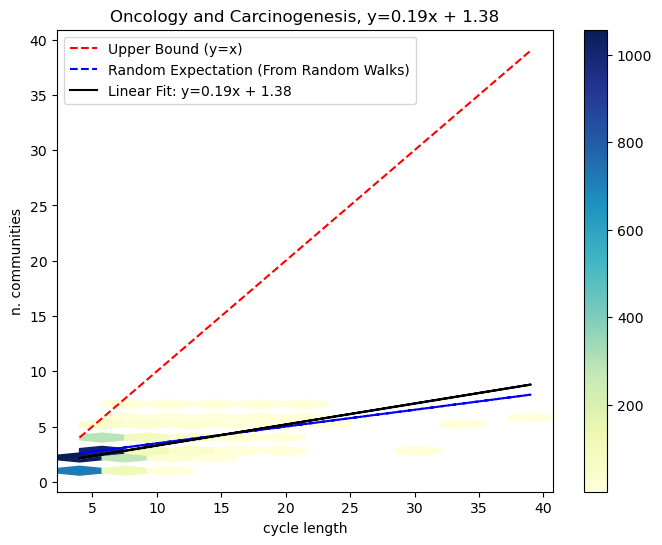

Processing Aerospace Engineering...
Filtered to 2620 cycles under length 100 (from 2620)
Skipped Aerospace Engineering: IndexError
Processing Pharmacology and Pharmaceutical Sciences...
Filtered to 3917 cycles under length 100 (from 3917)


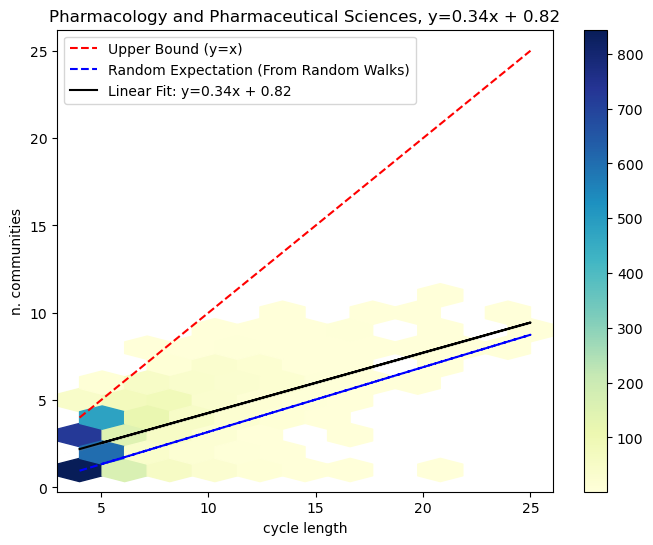

Processing Nutrition and Dietetics...
Filtered to 337 cycles under length 100 (from 337)


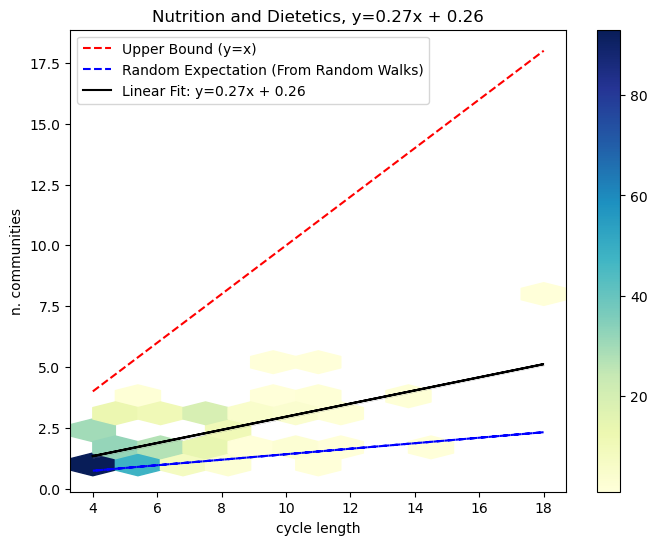

Processing Classical Physics...
Filtered to 1418 cycles under length 100 (from 1418)
Skipped Classical Physics: IndexError
Processing Medical Physiology...
Filtered to 717 cycles under length 100 (from 717)


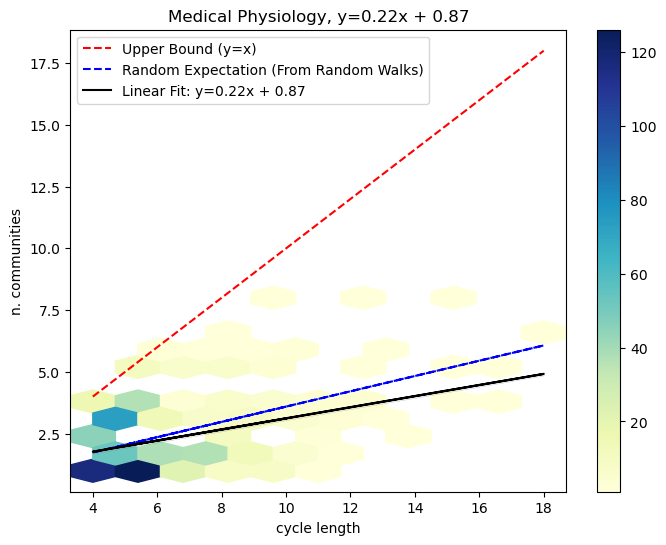

Processing Library and Information Studies...
Filtered to 3667 cycles under length 100 (from 3667)
Skipped Library and Information Studies: IndexError
Processing Analytical Chemistry...
Filtered to 12284 cycles under length 100 (from 12284)


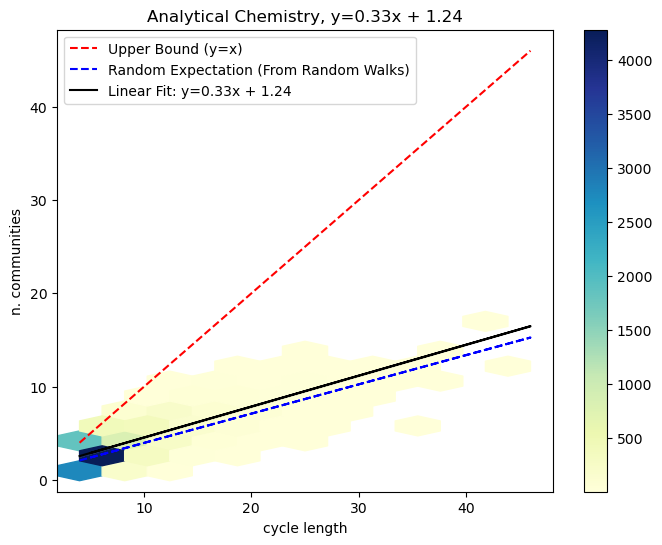

Processing Agriculture Land and Farm Management...
Filtered to 5445 cycles under length 100 (from 5445)
Skipped Agriculture Land and Farm Management: IndexError
Processing Commercial Services...
Filtered to 1739 cycles under length 100 (from 1739)
Skipped Commercial Services: IndexError
Processing Performing Arts and Creative Writing...
Filtered to 4011 cycles under length 100 (from 4011)
Skipped Performing Arts and Creative Writing: IndexError
Processing Clinical Sciences...
Filtered to 5168 cycles under length 100 (from 5168)


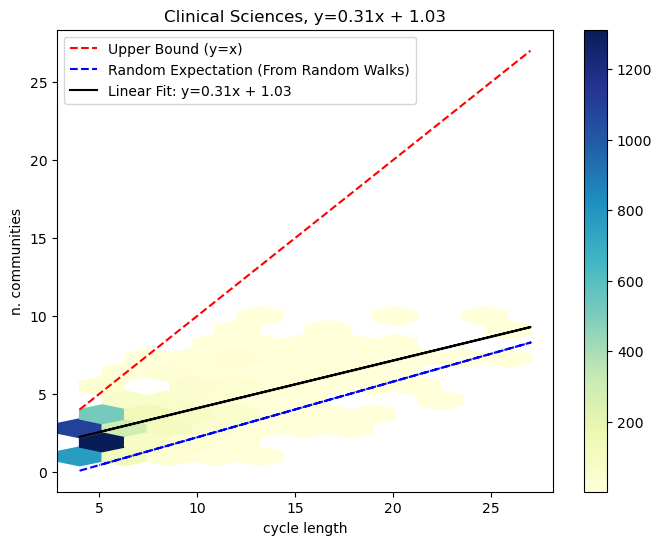

Processing Theoretical and Computational Chemistry...
Filtered to 10464 cycles under length 100 (from 10464)


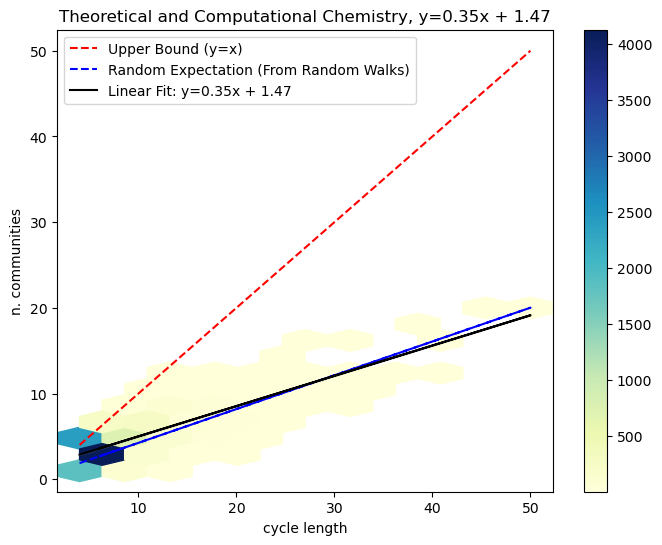

Processing Communication and Media Studies...
Filtered to 2634 cycles under length 100 (from 2634)
Skipped Communication and Media Studies: IndexError
Processing Other Medical and Health Sciences...
Filtered to 300 cycles under length 100 (from 300)


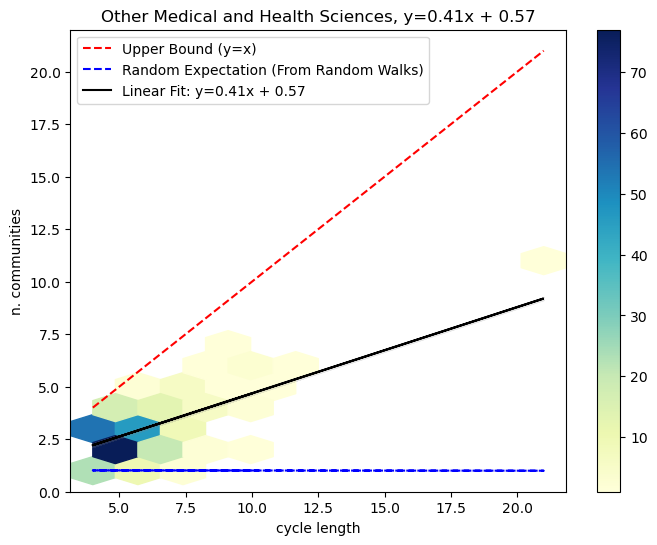

Processing Manufacturing Engineering...
Filtered to 7323 cycles under length 100 (from 7323)


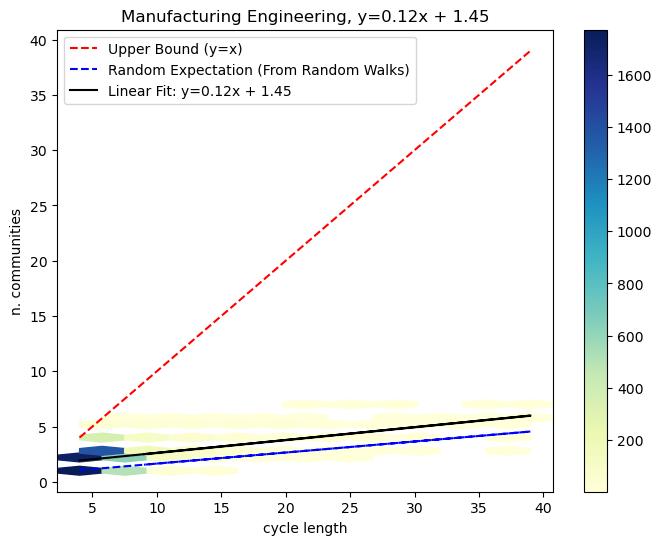

Processing Applied Ethics...
Filtered to 2361 cycles under length 100 (from 2361)
Skipped Applied Ethics: IndexError
Processing Visual Arts and Crafts...
Filtered to 75 cycles under length 100 (from 75)


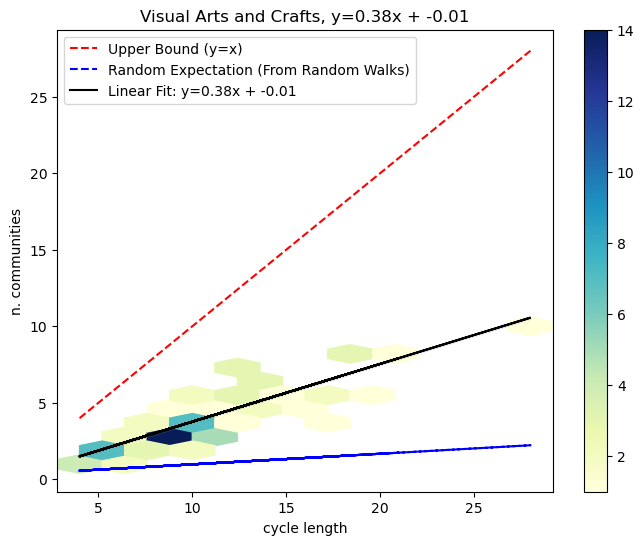

Processing Other Agricultural and Veterinary Sciences...
Filtered to 945 cycles under length 100 (from 945)
Skipped Other Agricultural and Veterinary Sciences: IndexError
Processing Film Television and Digital Media...
Filtered to 3549 cycles under length 100 (from 3549)
Skipped Film Television and Digital Media: IndexError
Processing Demography...
Filtered to 9736 cycles under length 100 (from 9736)


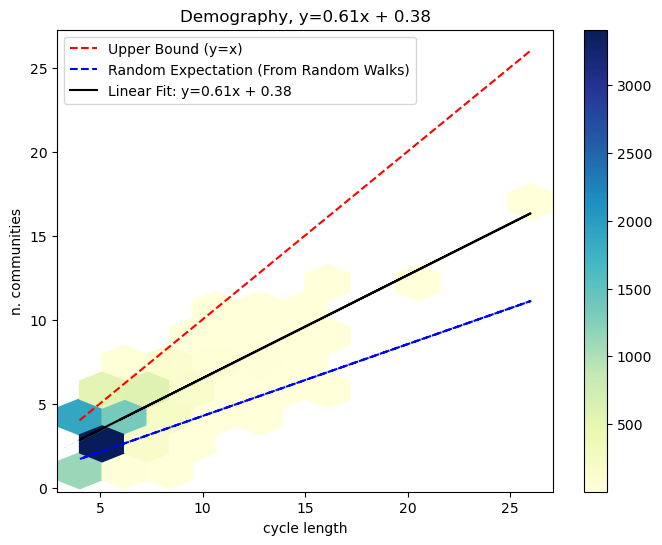

Processing Veterinary Sciences...
Filtered to 3974 cycles under length 100 (from 3975)


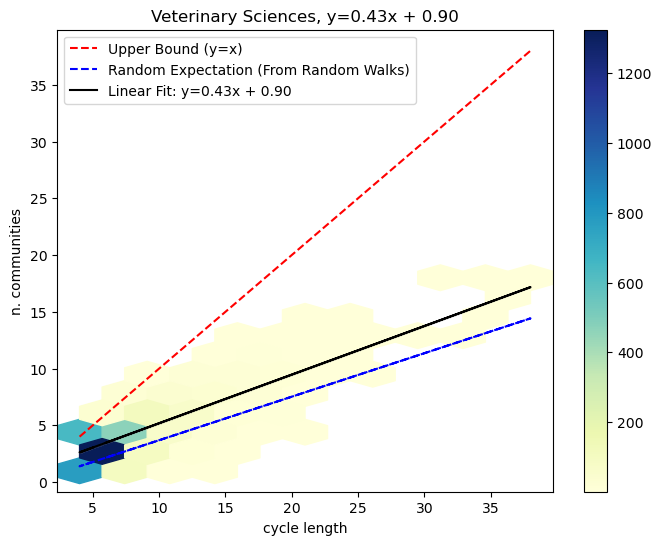

Processing Other Information and Computing Sciences...
Filtered to 232 cycles under length 100 (from 232)
Skipped Other Information and Computing Sciences: IndexError
Processing Language Studies...
Filtered to 11887 cycles under length 100 (from 11887)
Skipped Language Studies: IndexError
Processing Resources Engineering and Extractive Metallurgy...
Filtered to 9813 cycles under length 100 (from 9813)


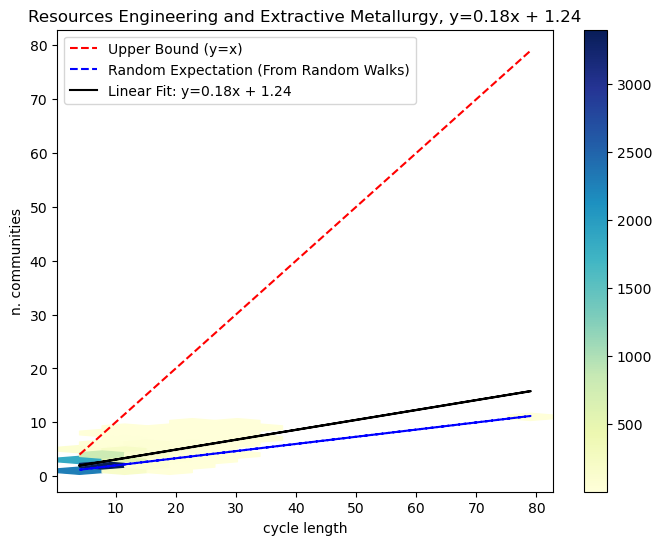

Processing Cardiorespiratory Medicine and Haematology...
Filtered to 4868 cycles under length 100 (from 4869)


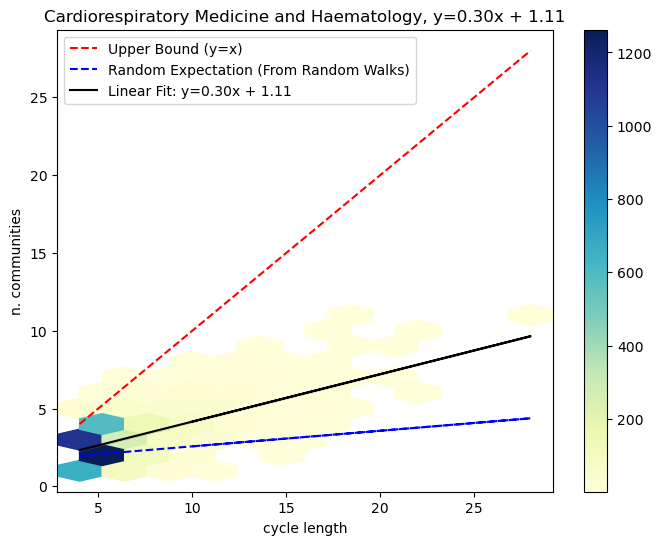

Processing Agricultural Biotechnology...
Filtered to 738 cycles under length 100 (from 738)
Skipped Agricultural Biotechnology: IndexError
Processing Curatorial and Related Studies...
Filtered to 1540 cycles under length 100 (from 1540)
Skipped Curatorial and Related Studies: IndexError
Processing Automotive Engineering...
Filtered to 80 cycles under length 100 (from 80)


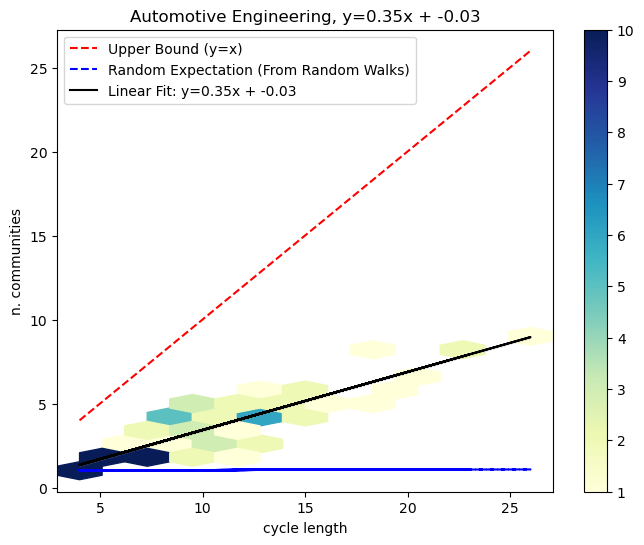

Processing Animal Production...
Filtered to 5205 cycles under length 100 (from 5205)
Skipped Animal Production: IndexError
Processing Human Movement and Sports Science...
Filtered to 1697 cycles under length 100 (from 1697)
Skipped Human Movement and Sports Science: IndexError
Processing Other Technology...
Filtered to 3 cycles under length 100 (from 3)


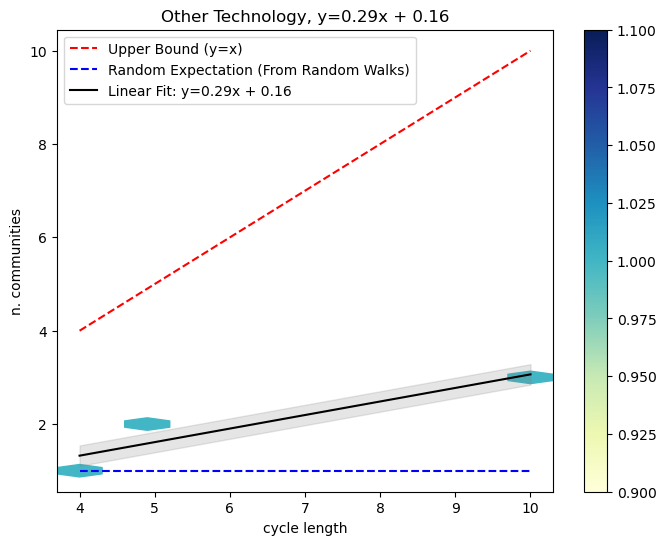

Processing Environmental Biotechnology...
Filtered to 0 cycles under length 100 (from 0)
Skipped Environmental Biotechnology: ValueError - min() iterable argument is empty
Processing Medical Microbiology...
Filtered to 2714 cycles under length 100 (from 2714)


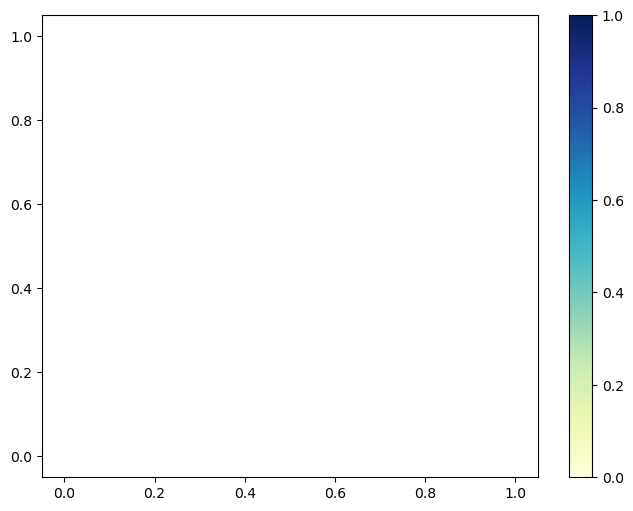

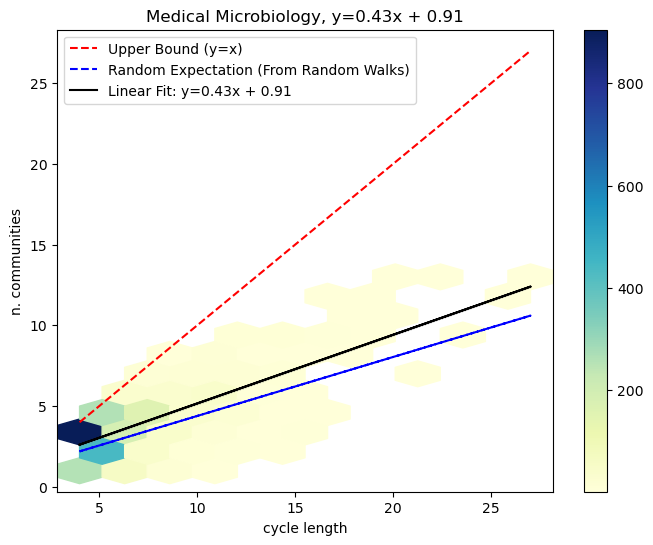

Processing Paediatrics and Reproductive Medicine...
Filtered to 1957 cycles under length 100 (from 1957)


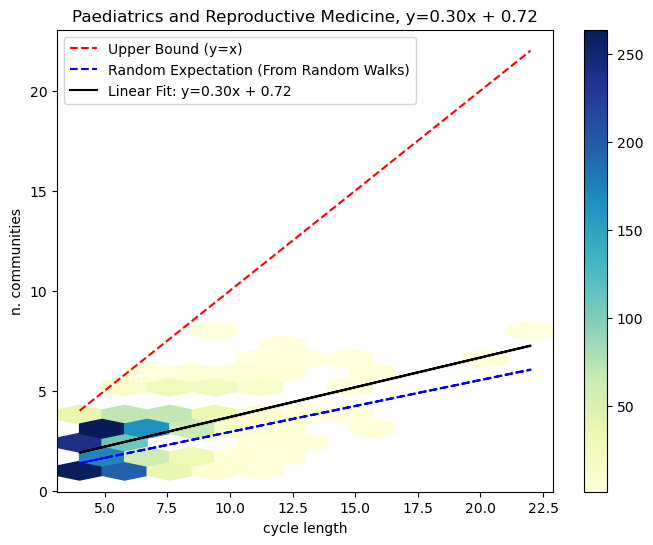

Processing Nanotechnology...
Filtered to 10035 cycles under length 100 (from 10035)


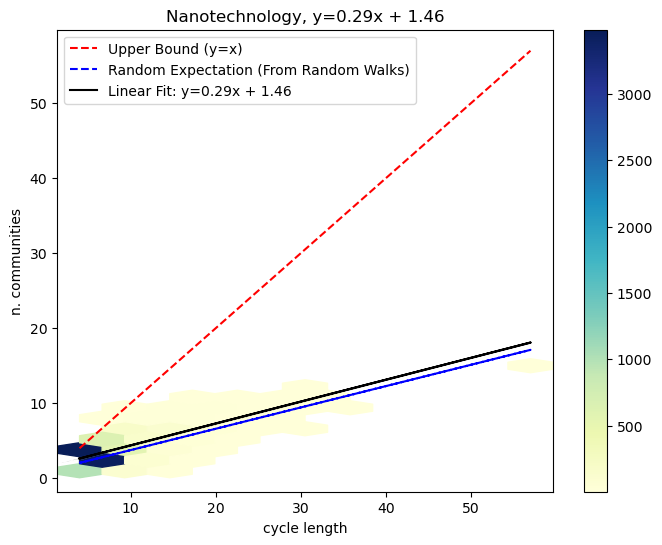

Processing Other Engineering...
Filtered to 47 cycles under length 100 (from 47)


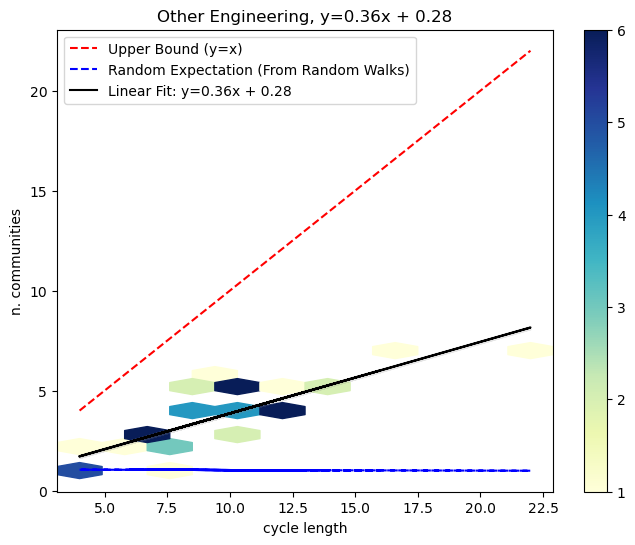

Processing Complementary and Alternative Medicine...
Filtered to 69 cycles under length 100 (from 69)


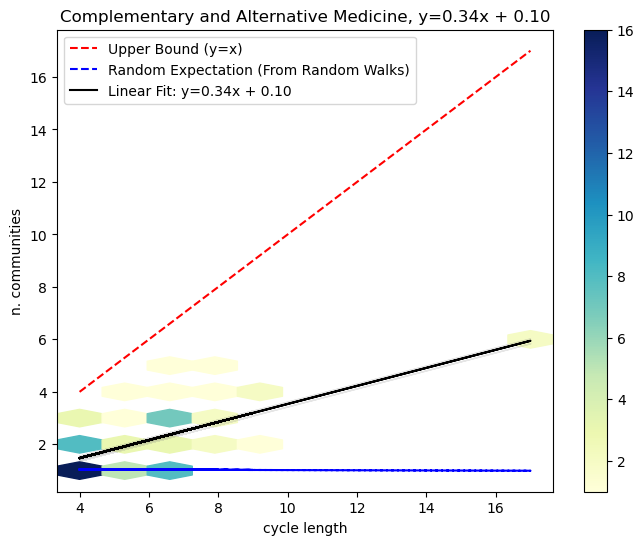

Processing Zoology...
Filtered to 4939 cycles under length 100 (from 4939)


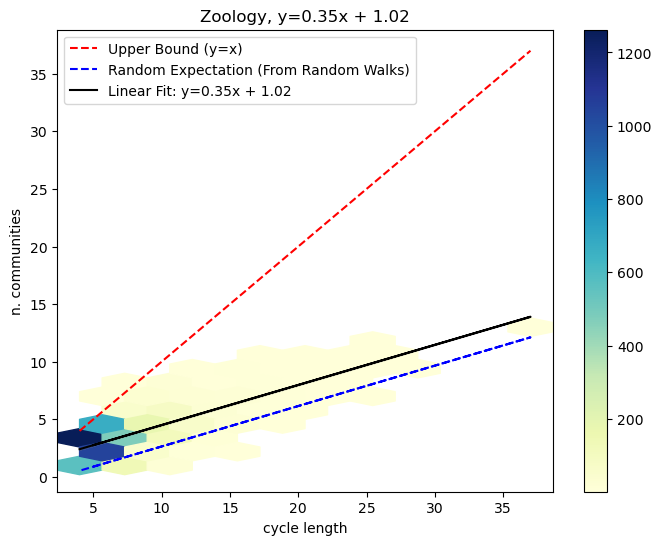

Processing Food Sciences...
Filtered to 2011 cycles under length 100 (from 2011)


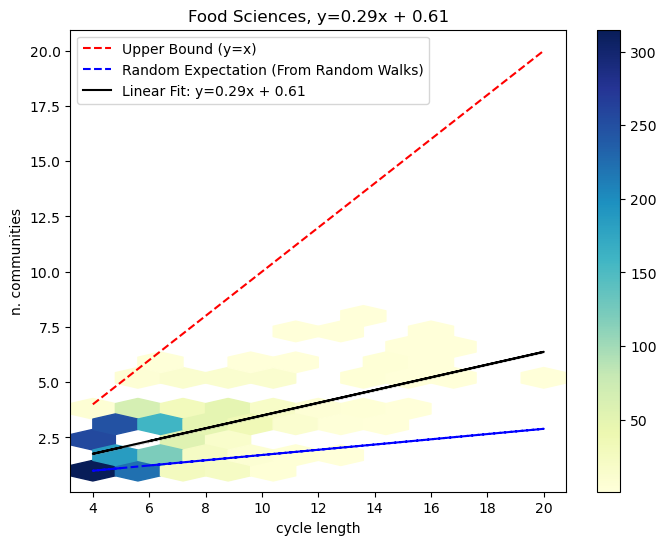

Processing Urban and Regional Planning...
Filtered to 7413 cycles under length 100 (from 7413)
Skipped Urban and Regional Planning: IndexError
Processing Other Studies In Human Society...
Filtered to 17586 cycles under length 100 (from 17586)


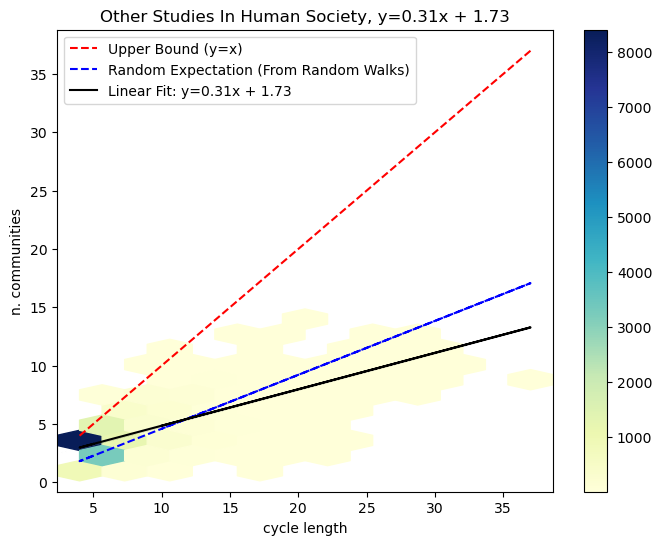

Processing Ophthalmology and Optometry...
Skipped Ophthalmology and Optometry: IndexError
Processing Biomedical Engineering...
Filtered to 4753 cycles under length 100 (from 4753)


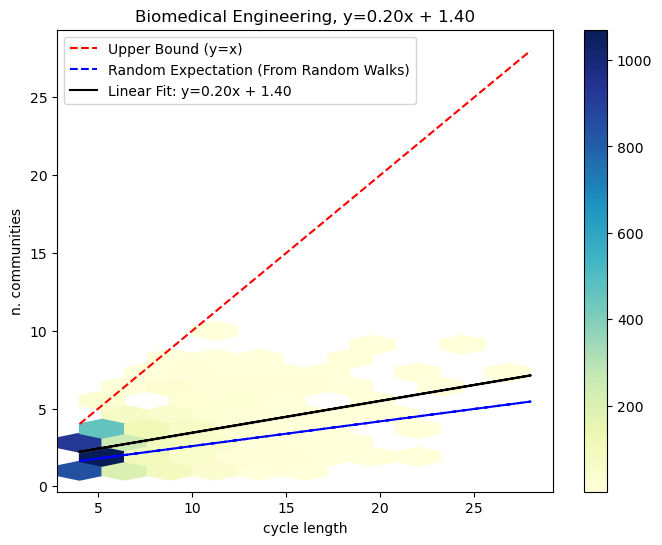

Processing Building...
Filtered to 8397 cycles under length 100 (from 8397)
Skipped Building: IndexError
Processing Quantum Physics...
Filtered to 10292 cycles under length 100 (from 10292)


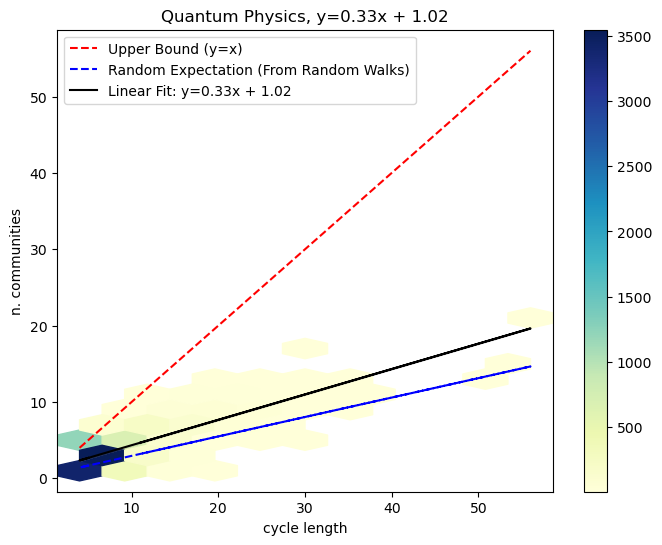

Processing Maritime Engineering...
Filtered to 2844 cycles under length 100 (from 2844)
Skipped Maritime Engineering: IndexError
Processing Journalism and Professional Writing...
Filtered to 313 cycles under length 100 (from 313)
Skipped Journalism and Professional Writing: IndexError
Processing Anthropology...
Filtered to 5777 cycles under length 100 (from 5777)


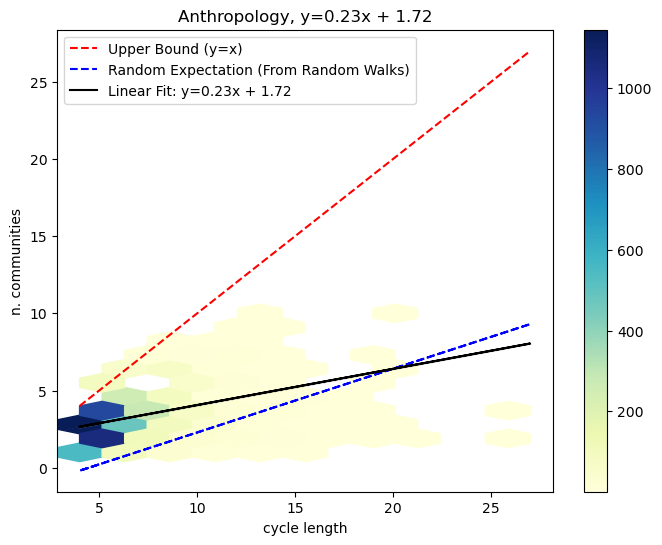

Processing Nursing...
Filtered to 3402 cycles under length 100 (from 3402)


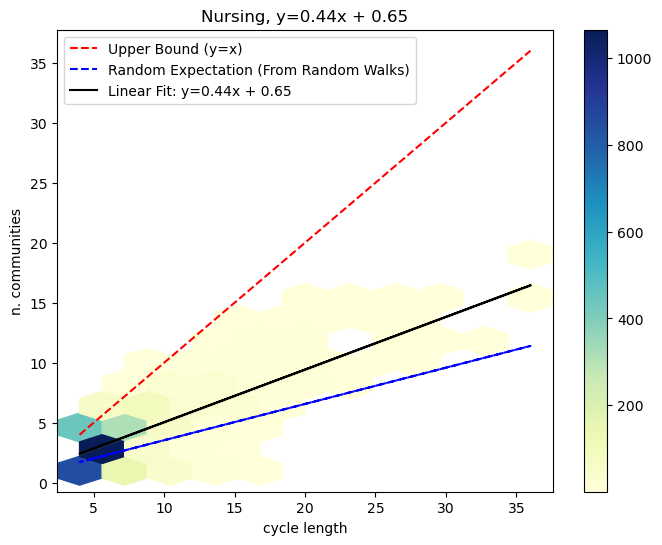

Processing Medical Biochemistry and Metabolomics...
Filtered to 246 cycles under length 100 (from 246)


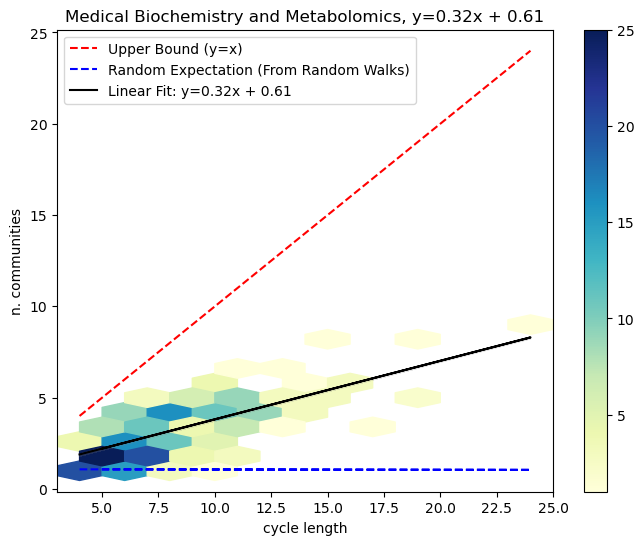

Processing Computer Hardware...
Filtered to 288 cycles under length 100 (from 288)
Skipped Computer Hardware: IndexError
Processing History and Philosophy of Specific Fields...
Filtered to 7010 cycles under length 100 (from 7010)


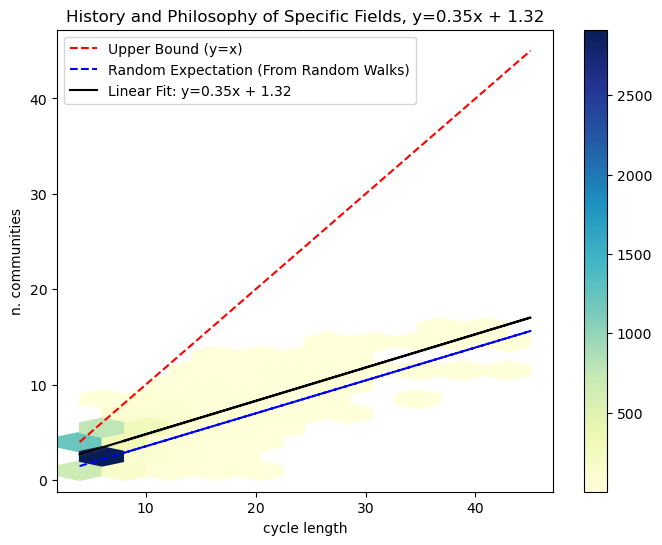

Processing Fisheries Sciences...
Filtered to 5090 cycles under length 100 (from 5090)
Skipped Fisheries Sciences: IndexError
Processing Evolutionary Biology...
Filtered to 12730 cycles under length 100 (from 12731)


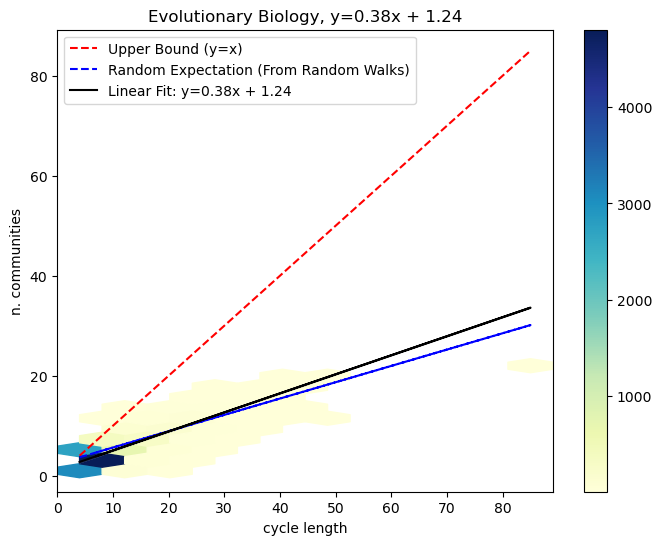

Processing Tourism...
Filtered to 4061 cycles under length 100 (from 4061)
Skipped Tourism: IndexError
Processing Medicinal and Biomolecular Chemistry...
Filtered to 743 cycles under length 100 (from 743)


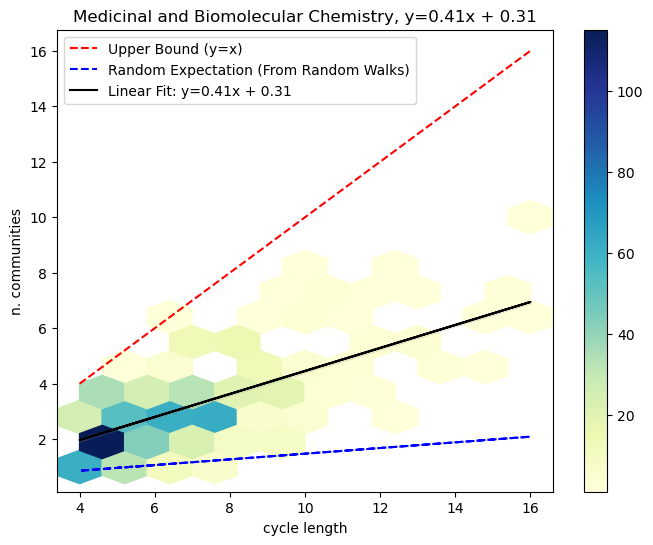

Processing Education Systems...
Filtered to 4259 cycles under length 100 (from 4259)
Skipped Education Systems: IndexError
Processing Marketing...
Filtered to 6617 cycles under length 100 (from 6617)


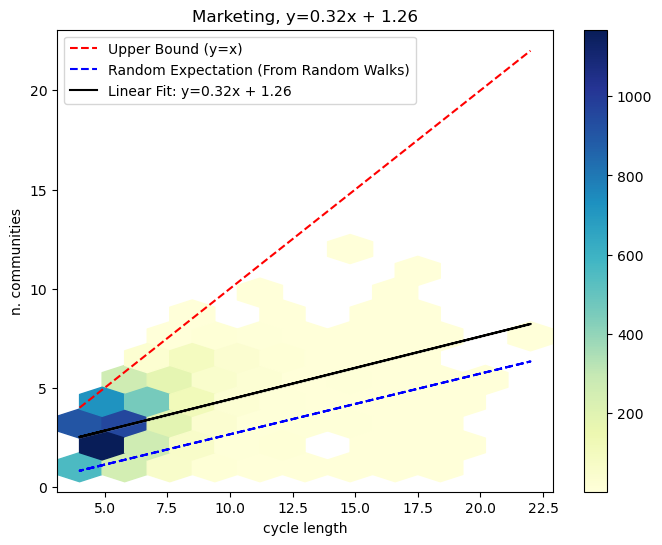

Processing Design Practice and Management...
Filtered to 684 cycles under length 100 (from 684)
Skipped Design Practice and Management: IndexError
Processing Economic Theory...
Filtered to 13562 cycles under length 100 (from 13563)
Skipped Economic Theory: IndexError
Processing Transportation and Freight Services...
Filtered to 2802 cycles under length 100 (from 2802)
Skipped Transportation and Freight Services: IndexError
Processing Art Theory and Criticism...
Filtered to 66 cycles under length 100 (from 66)


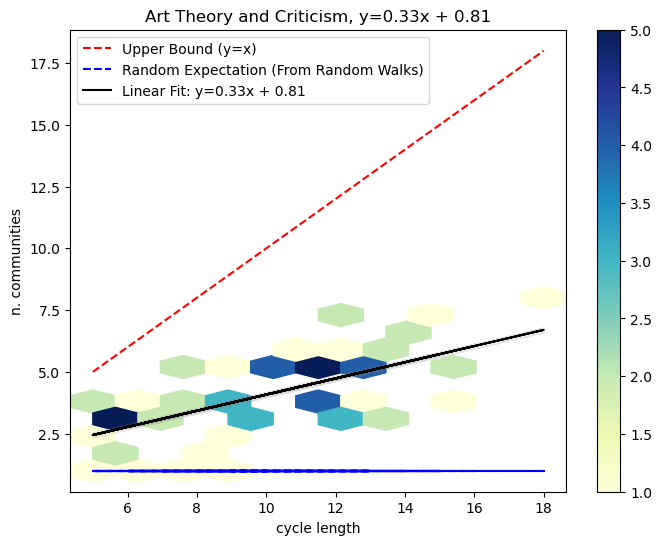

Processing Dentistry...
Filtered to 428 cycles under length 100 (from 428)


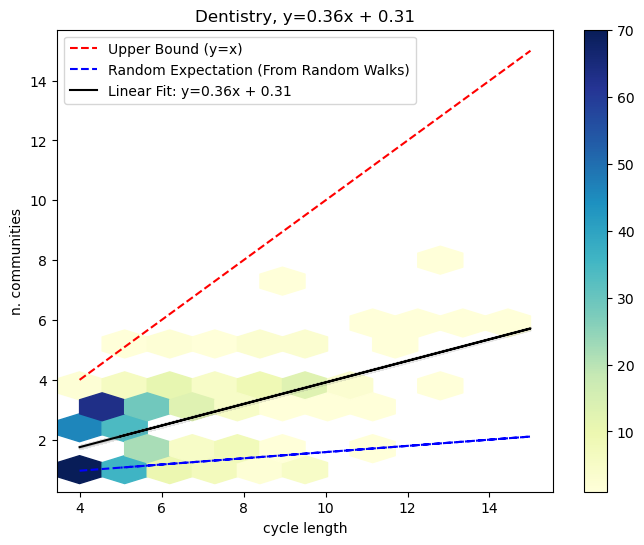

Processing Immunology...
Filtered to 2171 cycles under length 100 (from 2171)


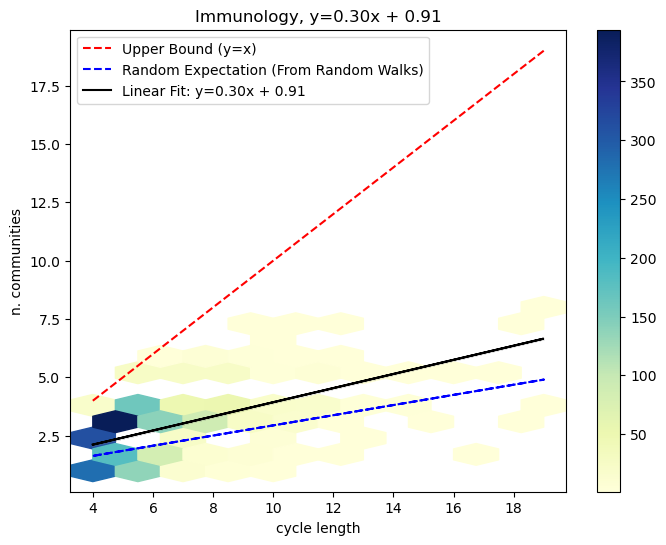

Processing Other Economics...
Filtered to 219 cycles under length 100 (from 219)


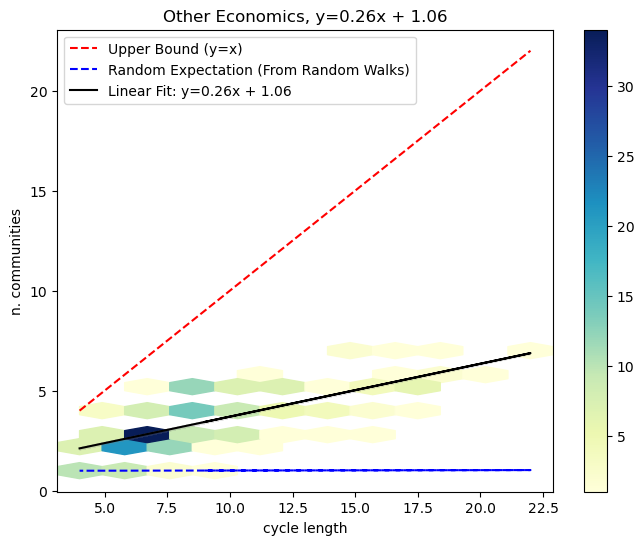

Processing Computation Theory and Mathematics...
Filtered to 13487 cycles under length 100 (from 13488)


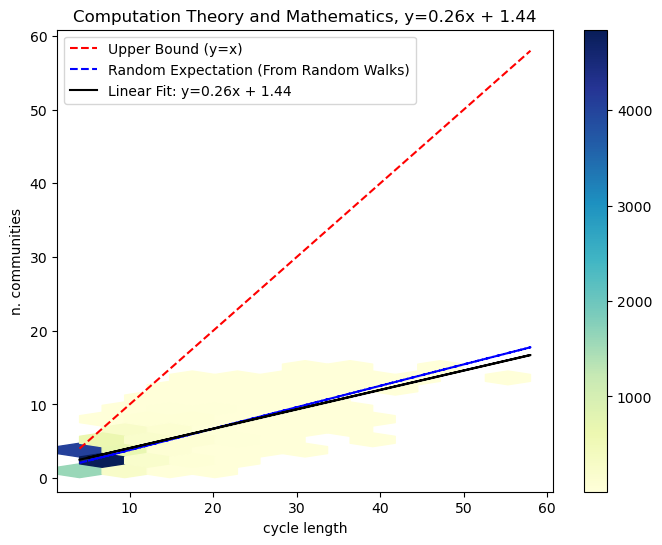

Processing Medical Biotechnology...
Filtered to 542 cycles under length 100 (from 542)
Skipped Medical Biotechnology: IndexError
Processing Industrial Biotechnology...
Filtered to 226 cycles under length 100 (from 226)


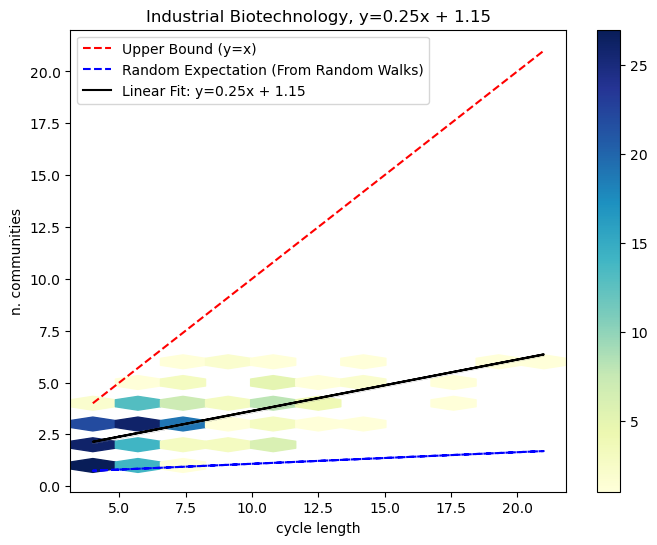

Processing Distributed Computing...
Filtered to 5793 cycles under length 100 (from 5793)
Skipped Distributed Computing: IndexError
Processing Interdisciplinary Engineering...
Filtered to 14292 cycles under length 100 (from 14292)


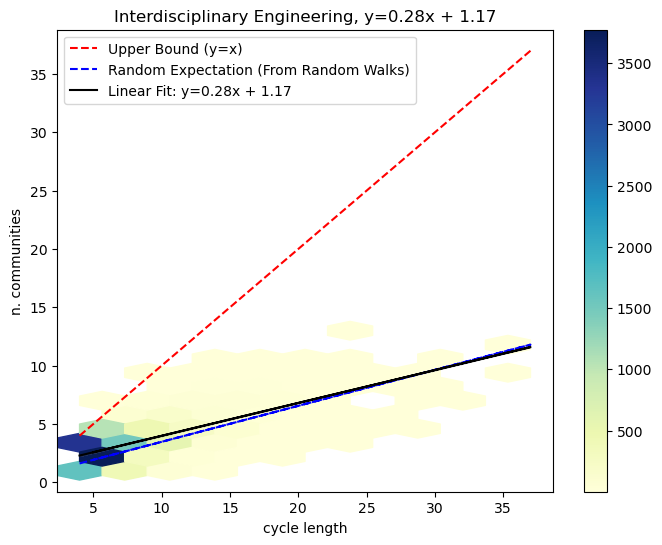

Processing Architecture...
Filtered to 8270 cycles under length 100 (from 8270)
Skipped Architecture: IndexError
Processing Horticultural Production...
Filtered to 5417 cycles under length 100 (from 5417)
Skipped Horticultural Production: IndexError
Processing Physiology...
Filtered to 1070 cycles under length 100 (from 1070)
Skipped Physiology: IndexError
Processing Archaeology...
Filtered to 13366 cycles under length 100 (from 13366)
Skipped Archaeology: IndexError
Processing Social Work...
Filtered to 5566 cycles under length 100 (from 5566)


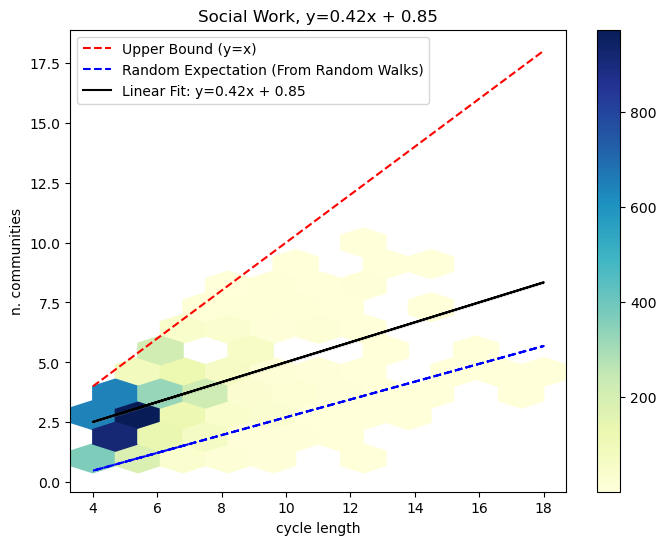

Processing Mechanical Engineering...
Filtered to 7154 cycles under length 100 (from 7154)


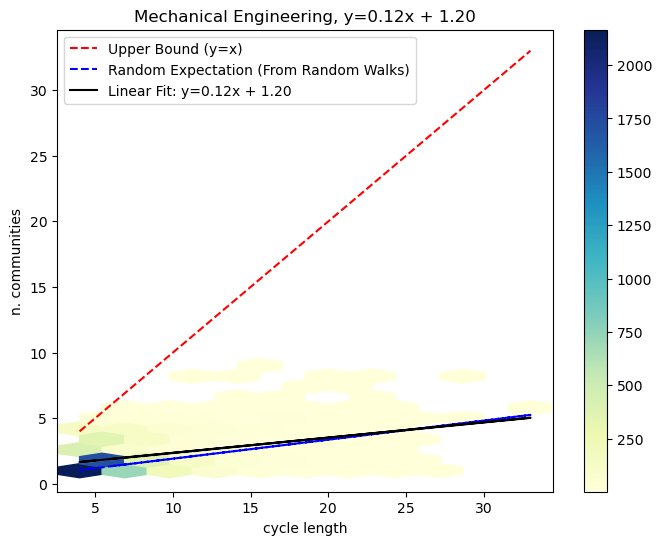

In [94]:
import os

base_dir = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025"
triopt_dir = os.path.join(base_dir, "tri_opt")
graphs_dir = os.path.join(base_dir, "graphs")

for filename in os.listdir(triopt_dir):
    if filename.endswith(".pkl"):
        triopt_path = os.path.join(triopt_dir, filename)
        graph_path = os.path.join(graphs_dir, filename)

        if os.path.exists(graph_path):
            domain_name = os.path.splitext(filename)[0]
            print(f"Processing {domain_name}...")

            try:
                reps, G_snapshots = load_data(triopt_path, graph_path)
                process_data(reps, G_snapshots, domain_name)
            except IndexError:
                print(f"Skipped {domain_name}: IndexError")
            except Exception as e:
                print(f"Skipped {domain_name}: {type(e).__name__} - {e}")


In [2]:
horseshoe = ['Psychology',
 'Biochemistry and Cell Biology',
 'Atomic Molecular Nuclear Particle and Plasma Physics',
 'Other Physical Sciences',
 'Environmental Science and Management',
 'Physical Geography and Environmental Geoscience',
 'Applied Economics',
 'Curriculum and Pedagogy',
 'Soil Sciences',
 'Astronomical and Space Sciences',
 'Crop and Pasture Production',
 'Artificial Intelligence and Image Processing',
 'Oceanography',
 'Plant Biology',
 'Business and Management',
 'Law',
 'Macromolecular and Materials Chemistry',
 'Historical Studies',
 'Atmospheric Sciences',
 'Communications Technologies',
 'Inorganic Chemistry',
 'Applied Mathematics',
 'Interdisciplinary Engineering',
 'Information Systems',
 'Political Science',
 'Geophysics',
 'Sociology',
 'Civil Engineering',
 'Electrical and Electronic Engineering',
 'Banking Finance and Investment',
 'Paediatrics and Reproductive Medicine',
 'Chemical Engineering',
 'Pure Mathematics',
 'Econometrics',
 'Environmental Engineering',
 'Microbiology',
 'Linguistics',
 'Policy and Administration',
 'Pharmacology and Pharmaceutical Sciences',
 'Optical Physics',
 'Other Chemical Sciences',
 'Analytical Chemistry',
 'Cognitive Sciences',
 'Neurosciences',
 'Clinical Sciences',
 'Oncology and Carcinogenesis',
 'Mechanical Engineering',
 'Cultural Studies',
 'Cardiorespiratory Medicine and Haematology',
 'Numerical and Computational Mathematics',
 'Statistics',
 'Philosophy',
 'Public Health and Health Services',
 'Resources Engineering and Extractive Metallurgy',
 'Condensed Matter Physics',
 'Geomatic Engineering',
 'Computer Software',
 'Religion and Religious Studies',
 'Literary Studies',
 'Organic Chemistry',
 'Forestry Sciences',
 'Quantum Physics',
 'Immunology',
 'Computation Theory and Mathematics',
 'Data Format',
 'Human Geography',
 'Manufacturing Engineering',
 'Evolutionary Biology',
 'Biomedical Engineering',
 'Archaeology',
 'Medical Microbiology',
 'Theoretical and Computational Chemistry',
 'Economic Theory',
 'Other Studies In Human Society',
 'Ecological Applications',
 'Accounting Auditing and Accountability',
 'History and Philosophy of Specific Fields',
 'Nanotechnology',
 'Criminology',
 'Demography',
 'Other Biological Sciences',
 'Marketing',
 'Urban and Regional Planning',
 'Language Studies',
 'Social Work',
 'Anthropology',
 'Fisheries Sciences',
 'Building',
 'Horticultural Production',
 'Zoology',
 'Agriculture Land and Farm Management',
 'Tourism',
 'Distributed Computing',
 'Nursing',
 'Architecture',
 'Veterinary Sciences',
 'Performing Arts and Creative Writing',
 'Film Television and Digital Media',
 'Animal Production',
 'Applied Ethics',
 'Library and Information Studies',
 'Transportation and Freight Services',
 'Maritime Engineering',
 'Education Systems',
 'Communication and Media Studies',
 'Food Sciences',
 'Aerospace Engineering',
 'Commercial Services',
 'Human Movement and Sports Science',
 'Medicinal and Biomolecular Chemistry',
 'Ophthalmology and Optometry',
 'Medical Biotechnology',
 'Physiology',
 'Dentistry',
 'Medical Physiology',
 'Classical Physics',
 'Other Agricultural and Veterinary Sciences',
 'Curatorial and Related Studies',
 'Nutrition and Dietetics',
 'Medical Biochemistry and Metabolomics',
 'Agricultural Biotechnology',
 'Design Practice and Management',
 'Journalism and Professional Writing',
 'Computer Hardware',
 'Other Economics',
 'Other Medical and Health Sciences',
 'Automotive Engineering',
 'Other Information and Computing Sciences',
 'Other Engineering',
 'Art Theory and Criticism',
 'Industrial Biotechnology',
 'Visual Arts and Crafts',
 'Other Technology',
 'Complementary and Alternative Medicine',
 'Environmental Biotechnology']

Filtered to 69 cycles under length 100 (from 69)


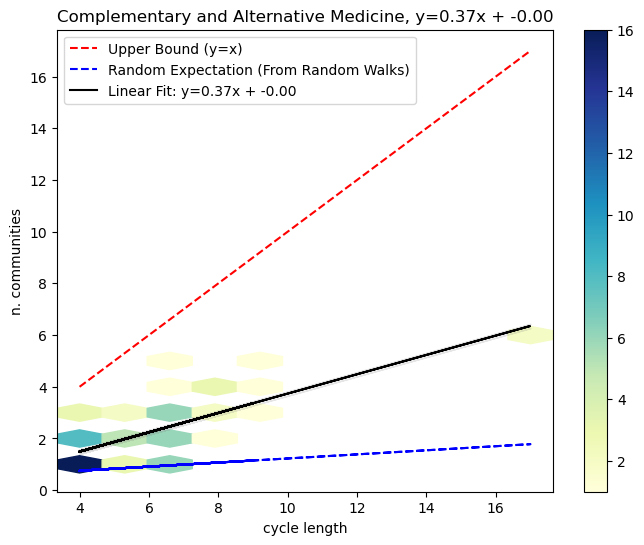

In [98]:
domain_name = "Complementary and Alternative Medicine"
cycle_reps_path = f"/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/tri_opt/{domain_name}.pkl"
graph_path = f"/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/graphs/{domain_name}.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 9813 cycles under length 100 (from 9813)


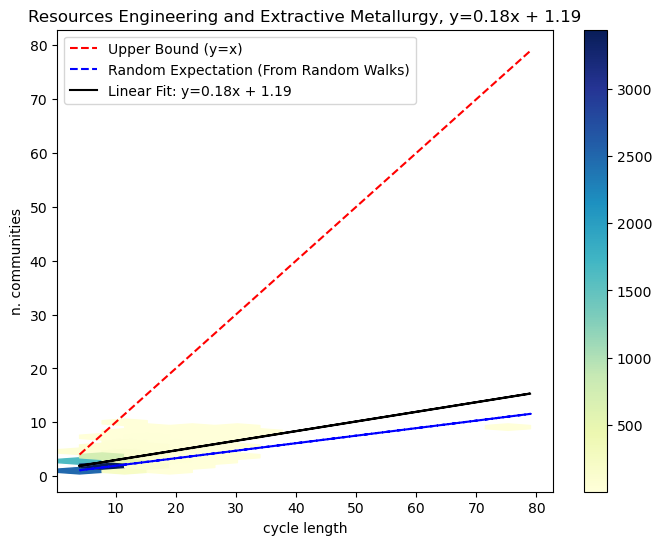

In [100]:
domain_name = "Resources Engineering and Extractive Metallurgy"
cycle_reps_path = f"/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/tri_opt/{domain_name}.pkl"
graph_path = f"/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/graphs/{domain_name}.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

Filtered to 14292 cycles under length 100 (from 14292)


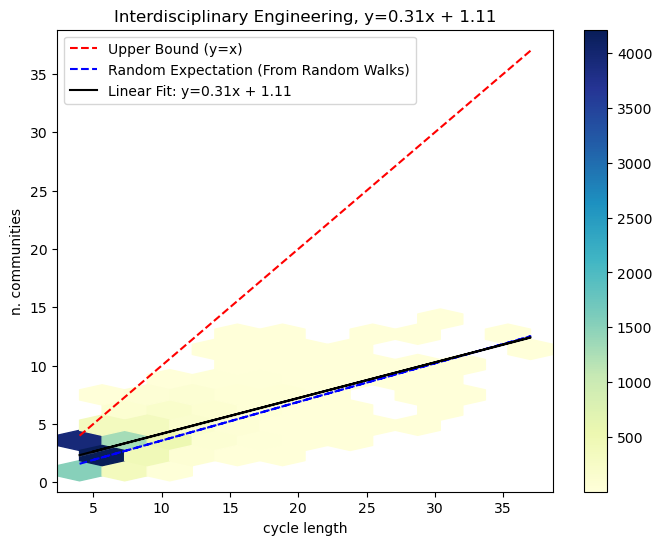

In [6]:
domain_name = "Interdisciplinary Engineering"
cycle_reps_path = f"/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/tri_opt/{domain_name}.pkl"
graph_path = f"/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025/graphs/{domain_name}.pkl"

reps, G_snapshots = load_data(cycle_reps_path, graph_path)
process_data(reps, G_snapshots, domain_name)

In [20]:
def horseshoe_to_scores(horseshoe):
    n = len(horseshoe)
    middle = (n - 1) / 2
    scores = {}
    for i, domain in enumerate(horseshoe):  # assuming middle is most developed?
        dist = abs(i - middle)
        score = 1 - dist / middle
        scores[domain] = score
    return scores

development_scores = horseshoe_to_scores(horseshoe)
print(development_scores)

{'Psychology': 0.0, 'Biochemistry and Cell Biology': 0.014925373134328401, 'Atomic Molecular Nuclear Particle and Plasma Physics': 0.02985074626865669, 'Other Physical Sciences': 0.04477611940298509, 'Environmental Science and Management': 0.05970149253731338, 'Physical Geography and Environmental Geoscience': 0.07462686567164178, 'Applied Economics': 0.08955223880597019, 'Curriculum and Pedagogy': 0.10447761194029848, 'Soil Sciences': 0.11940298507462688, 'Astronomical and Space Sciences': 0.13432835820895528, 'Crop and Pasture Production': 0.14925373134328357, 'Artificial Intelligence and Image Processing': 0.16417910447761197, 'Oceanography': 0.17910447761194026, 'Plant Biology': 0.19402985074626866, 'Business and Management': 0.20895522388059706, 'Law': 0.22388059701492535, 'Macromolecular and Materials Chemistry': 0.23880597014925375, 'Historical Studies': 0.25373134328358204, 'Atmospheric Sciences': 0.26865671641791045, 'Communications Technologies': 0.28358208955223885, 'Inorgan

In [5]:
def process_data_get_gap(reps, G_snapshots, domain_name):    
    dynamic_coms = algorithms.louvain(G_snapshots[-1], resolution=2)
    rog = len(reps)
    reps = [r for r in reps if len(r) < 100] 
    print(f"Filtered to {len(reps)} cycles under length 100 (from {rog})")

    coms = dynamic_coms.communities
    node_to_com_dict = {}
    for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
        for node in community:
            node_to_com_dict[node] = i
    # print(node_to_com_dict)

    big_rep_cycle_list1 = []
    for thing in reps:
        big_rep_cycle_list1.append(list(thing))

    filtered_big_reps = []
    for cycle in big_rep_cycle_list1:
        present = True
        for nodething in cycle:
            if nodething not in G_snapshots[-1].nodes():
                present = False
        if present:
            filtered_big_reps.append(cycle)

    import random

    G = G_snapshots[-1]

    def find_random_cycle(G, length, max_attempts=1000):
        nodes = list(G.nodes)
        if not nodes:
            return None

        for _ in range(max_attempts):
            start_node = random.choice(nodes)
            path = [start_node]
            visited = {start_node}

            current_node = start_node
            for _ in range(length - 1): 
                neighbors = [n for n in G.neighbors(current_node) if n not in visited]
                if not neighbors:
                    break  

                next_node = random.choice(neighbors)
                path.append(next_node)
                visited.add(next_node)
                current_node = next_node

            if len(path) == length and start_node in G.neighbors(current_node):
                path.append(start_node)
                return path

        return None 


    hole_lengths = []
    for item in filtered_big_reps:
        hole_lengths.append(len(item))

    G = G_snapshots[-1]

    found_cycles = []
    unique_coms = {}
    hole_lengths_index = 0
    for n in range(len(reps)-1):
        rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
        # print(rand_cycle)
        while (not rand_cycle) or (rand_cycle in found_cycles):
            rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
        found_cycles.append(rand_cycle)
        cycle_communities = [node_to_com_dict[node] for node in rand_cycle]
        unique_communities = set(cycle_communities)
        # unique_coms.append(len(unique_communities))
        if len(rand_cycle) in unique_coms.keys():
            unique_coms[len(rand_cycle)].append(len(unique_communities))
        else:
            unique_coms[len(rand_cycle)] = [len(unique_communities)]
        hole_lengths_index+=1

    coms = dynamic_coms.communities
    node_to_com_dict = {}
    for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
        for node in community:
            node_to_com_dict[node] = i
    # print(node_to_com_dict)

    big_rep_cycle_list1 = []
    for thing in reps:
        big_rep_cycle_list1.append(list(thing))

    filtered_big_reps = []
    for cycle in big_rep_cycle_list1:
        present = True
        for nodething in cycle:
            if nodething not in G_snapshots[-1].nodes():
                present = False
        if present:
            filtered_big_reps.append(cycle)

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats

    def expected_vals(unique_coms):
        sizes = []
        avg_coms_values = []

        for walk_length, com_list in unique_coms.items():
            avg_coms = np.mean(com_list)
            sizes.append(walk_length)
            avg_coms_values.append(avg_coms)

        sizes = np.array(sizes)
        avg_coms_values = np.array(avg_coms_values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(sizes, avg_coms_values)
        
        expected_line_equation = f"y = {slope:.2f}x + {intercept:.2f}"

        return slope, intercept


    topic = domain_name

    cycle_sizes = []
    community_counts = []

    for cycle in filtered_big_reps:
        communities = set(node_to_com_dict[node] for node in cycle)
        community_count = len(communities)
        cycle_sizes.append(len(cycle))
        community_counts.append(community_count)

    cycle_sizes = np.array(cycle_sizes)
    community_counts = np.array(community_counts)

    # plt.plot([min(cycle_sizes), 15], [min(cycle_sizes), 15], 'r--', label='Upper Bound (y=x)')

    s, i = expected_vals(unique_coms)
    expected_line = s * cycle_sizes + i

    slope, intercept, r_value, p_value, std_err = stats.linregress(cycle_sizes, community_counts)
    line_fit = slope * cycle_sizes + intercept

    x_min = min(cycle_sizes)
    x_max = max(cycle_sizes)
    x_grid = np.linspace(x_min, x_max, 5000)
    empirical_vals = slope * x_grid + intercept
    expected_vals_grid = s * x_grid + i
    diff = empirical_vals - expected_vals_grid
    signed_integrated_gap = np.trapz(diff, x_grid)

    print(f"Signed integrated gap for {topic}: {signed_integrated_gap}")

    return signed_integrated_gap

In [14]:
import os 
base_dir = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025"
triopt_dir = os.path.join(base_dir, "tri_opt")
graphs_dir = os.path.join(base_dir, "graphs")

gaps = {}

for filename in os.listdir(triopt_dir):
    if filename.endswith(".pkl"):
        triopt_path = os.path.join(triopt_dir, filename)
        graph_path = os.path.join(graphs_dir, filename)

        if os.path.exists(graph_path):
            domain_name = os.path.splitext(filename)[0]
            print(f"Processing {domain_name}...")

            try:
                reps, G_snapshots = load_data(triopt_path, graph_path)
                gaps[domain_name] = process_data_get_gap(reps, G_snapshots, domain_name)
            except IndexError:
                print(f"Skipped {domain_name}: IndexError")
            except Exception as e:
                print(f"Skipped {domain_name}: {type(e).__name__} - {e}")


Processing Oncology and Carcinogenesis...
Filtered to 3943 cycles under length 100 (from 3943)
Signed integrated gap for Oncology and Carcinogenesis: 14.406927250952789
Processing Aerospace Engineering...
Filtered to 2620 cycles under length 100 (from 2620)
Skipped Aerospace Engineering: IndexError
Processing Pharmacology and Pharmaceutical Sciences...
Filtered to 3917 cycles under length 100 (from 3917)
Signed integrated gap for Pharmacology and Pharmaceutical Sciences: 30.848832472012383
Processing Nutrition and Dietetics...
Filtered to 337 cycles under length 100 (from 337)
Signed integrated gap for Nutrition and Dietetics: 28.29545493911415
Processing Classical Physics...
Filtered to 1418 cycles under length 100 (from 1418)
Skipped Classical Physics: IndexError
Processing Medical Physiology...
Filtered to 717 cycles under length 100 (from 717)
Signed integrated gap for Medical Physiology: -14.083636285513307
Processing Library and Information Studies...
Filtered to 3667 cycles unde

In [15]:
gaps

{'Oncology and Carcinogenesis': np.float64(14.406927250952789),
 'Pharmacology and Pharmaceutical Sciences': np.float64(30.848832472012383),
 'Nutrition and Dietetics': np.float64(28.29545493911415),
 'Medical Physiology': np.float64(-14.083636285513307),
 'Analytical Chemistry': np.float64(7.8039520983047534),
 'Clinical Sciences': np.float64(55.32889861109152),
 'Theoretical and Computational Chemistry': np.float64(-0.8478550769799078),
 'Other Medical and Health Sciences': np.float64(69.67966843593425),
 'Manufacturing Engineering': np.float64(32.15268531252402),
 'Visual Arts and Crafts': np.float64(107.01027952126934),
 'Demography': np.float64(63.987026471641975),
 'Veterinary Sciences': np.float64(54.58856762536225),
 'Resources Engineering and Extractive Metallurgy': np.float64(198.70273857453532),
 'Cardiorespiratory Medicine and Haematology': np.float64(41.57574881001635),
 'Automotive Engineering': np.float64(86.8638338330329),
 'Other Technology': np.float64(9.8709677419354

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_gap_vs_development(gaps, development_scores):
    gap_domains = set(gaps.keys())
    dev_domains = set(development_scores.keys())

    # Intersection = domains that exist in BOTH dictionaries
    common_domains = gap_domains.intersection(dev_domains)

    if len(common_domains) == 0:
        raise ValueError("No domain names match between gaps and development_scores.")

    missing_gaps = dev_domains - gap_domains
    missing_devs = gap_domains - dev_domains

    if missing_gaps:
        print("Domains with development score but NO gap:", missing_gaps)
    if missing_devs:
        print("Domains with gap but NO development score:", missing_devs)

    # Build aligned arrays
    x = np.array([development_scores[d] for d in common_domains])
    y = np.array([gaps[d] for d in common_domains])
    domains = list(common_domains)

    # Linear regression
    slope, intercept, r, p, stderr = stats.linregress(x, y)
    line = slope * x + intercept

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=90, color='steelblue')

    # Label points
    for d, xi, yi in zip(domains, x, y):
        plt.text(xi, yi, d, fontsize=7, ha='left', va='bottom')

    plt.xlabel("Dev Score (1 = most developed)")
    plt.ylabel("Integrated Gap Score")
    plt.title("Domain Dev vs. Gap")

    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()


Domains with development score but NO gap: {'Oceanography', 'Architecture', 'Literary Studies', 'Tourism', 'Applied Economics', 'Other Chemical Sciences', 'Chemical Engineering', 'Data Format', 'Inorganic Chemistry', 'Library and Information Studies', 'Policy and Administration', 'Public Health and Health Services', 'Atomic Molecular Nuclear Particle and Plasma Physics', 'Urban and Regional Planning', 'Other Biological Sciences', 'Electrical and Electronic Engineering', 'Design Practice and Management', 'Forestry Sciences', 'Medical Biotechnology', 'Linguistics', 'Artificial Intelligence and Image Processing', 'Soil Sciences', 'Economic Theory', 'Communication and Media Studies', 'Language Studies', 'Political Science', 'Cultural Studies', 'Applied Ethics', 'Atmospheric Sciences', 'Banking Finance and Investment', 'Geomatic Engineering', 'Horticultural Production', 'Environmental Engineering', 'Classical Physics', 'Religion and Religious Studies', 'Aerospace Engineering', 'Animal Produ

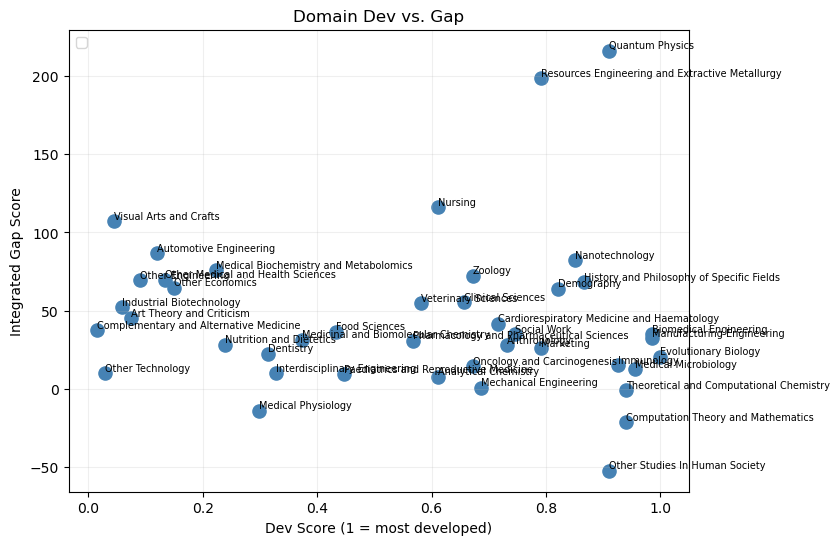

In [25]:
plot_gap_vs_development(gaps, development_scores)


In [4]:
def process_data_get_features(reps, G_snapshots, domain_name):    
    dynamic_coms = algorithms.louvain(G_snapshots[-1], resolution=2)
    rog = len(reps)
    reps = [r for r in reps if len(r) < 100] 
    print(f"Filtered to {len(reps)} cycles under length 100 (from {rog})")

    coms = dynamic_coms.communities
    node_to_com_dict = {}
    for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
        for node in community:
            node_to_com_dict[node] = i
    # print(node_to_com_dict)

    big_rep_cycle_list1 = []
    for thing in reps:
        big_rep_cycle_list1.append(list(thing))

    filtered_big_reps = []
    for cycle in big_rep_cycle_list1:
        present = True
        for nodething in cycle:
            if nodething not in G_snapshots[-1].nodes():
                present = False
        if present:
            filtered_big_reps.append(cycle)

    import random

    G = G_snapshots[-1]

    def find_random_cycle(G, length, max_attempts=1000):
        nodes = list(G.nodes)
        if not nodes:
            return None

        for _ in range(max_attempts):
            start_node = random.choice(nodes)
            path = [start_node]
            visited = {start_node}

            current_node = start_node
            for _ in range(length - 1): 
                neighbors = [n for n in G.neighbors(current_node) if n not in visited]
                if not neighbors:
                    break  

                next_node = random.choice(neighbors)
                path.append(next_node)
                visited.add(next_node)
                current_node = next_node

            if len(path) == length and start_node in G.neighbors(current_node):
                path.append(start_node)
                return path

        return None 


    hole_lengths = []
    for item in filtered_big_reps:
        hole_lengths.append(len(item))

    G = G_snapshots[-1]

    found_cycles = []
    unique_coms = {}
    hole_lengths_index = 0
    for n in range(len(reps)-1):
        rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
        # print(rand_cycle)
        while (not rand_cycle) or (rand_cycle in found_cycles):
            rand_cycle = find_random_cycle(G, hole_lengths[hole_lengths_index])
        found_cycles.append(rand_cycle)
        cycle_communities = [node_to_com_dict[node] for node in rand_cycle]
        unique_communities = set(cycle_communities)
        # unique_coms.append(len(unique_communities))
        if len(rand_cycle) in unique_coms.keys():
            unique_coms[len(rand_cycle)].append(len(unique_communities))
        else:
            unique_coms[len(rand_cycle)] = [len(unique_communities)]
        hole_lengths_index+=1

    coms = dynamic_coms.communities
    node_to_com_dict = {}
    for i, community in enumerate(coms):  # create a dictionary of {node : community the node is in}
        for node in community:
            node_to_com_dict[node] = i
    # print(node_to_com_dict)

    big_rep_cycle_list1 = []
    for thing in reps:
        big_rep_cycle_list1.append(list(thing))

    filtered_big_reps = []
    for cycle in big_rep_cycle_list1:
        present = True
        for nodething in cycle:
            if nodething not in G_snapshots[-1].nodes():
                present = False
        if present:
            filtered_big_reps.append(cycle)

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats

    def expected_vals(unique_coms):
        sizes = []
        avg_coms_values = []

        for walk_length, com_list in unique_coms.items():
            avg_coms = np.mean(com_list)
            sizes.append(walk_length)
            avg_coms_values.append(avg_coms)

        sizes = np.array(sizes)
        avg_coms_values = np.array(avg_coms_values)
        slope, intercept, r_value, p_value, std_err = stats.linregress(sizes, avg_coms_values)
        
        expected_line_equation = f"y = {slope:.2f}x + {intercept:.2f}"

        return slope, intercept


    topic = domain_name

    cycle_sizes = []
    community_counts = []

    for cycle in filtered_big_reps:
        communities = set(node_to_com_dict[node] for node in cycle)
        community_count = len(communities)
        cycle_sizes.append(len(cycle))
        community_counts.append(community_count)

    cycle_sizes = np.array(cycle_sizes)
    community_counts = np.array(community_counts)

    # plt.plot([min(cycle_sizes), 15], [min(cycle_sizes), 15], 'r--', label='Upper Bound (y=x)')

    s, i = expected_vals(unique_coms)
    expected_line = s * cycle_sizes + i

    slope, intercept, r_value, p_value, std_err = stats.linregress(cycle_sizes, community_counts)
    line_fit = slope * cycle_sizes + intercept

    x_min = min(cycle_sizes)
    x_max = max(cycle_sizes)
    x_grid = np.linspace(x_min, x_max, 5000)
    empirical_vals = slope * x_grid + intercept
    expected_vals_grid = s * x_grid + i
    diff = empirical_vals - expected_vals_grid
    signed_integrated_gap = np.trapz(diff, x_grid)

    x_range = float(np.max(cycle_sizes) - np.min(cycle_sizes))
    y_range = float(np.max(community_counts) - np.min(community_counts))
    expected_slope = float(s)
    empirical_slope = float(slope)

    return {
    "x_range": x_range,
    "y_range": y_range,
    "expected_slope": expected_slope,
    "empirical_slope": empirical_slope,
    "integrated_gap": float(signed_integrated_gap)
    }

In [6]:
import os 
base_dir = "/Users/francesmcconnell/Desktop/TDA Sci-Sci Research/October 2025"
triopt_dir = os.path.join(base_dir, "tri_opt")
graphs_dir = os.path.join(base_dir, "graphs")

domain_features = {}

for filename in os.listdir(triopt_dir):
    if filename.endswith(".pkl"):
        triopt_path = os.path.join(triopt_dir, filename)
        graph_path = os.path.join(graphs_dir, filename)

        if os.path.exists(graph_path):
            domain_name = os.path.splitext(filename)[0]
            print(f"Processing {domain_name}...")

            try:
                reps, G_snapshots = load_data(triopt_path, graph_path)
                domain_features[domain_name] = process_data_get_features(reps, G_snapshots, domain_name)
            except IndexError:
                print(f"Skipped {domain_name}: IndexError")
            except Exception as e:
                print(f"Skipped {domain_name}: {type(e).__name__} - {e}")


Processing Oncology and Carcinogenesis...
Filtered to 3943 cycles under length 100 (from 3943)
Processing Aerospace Engineering...
Filtered to 2620 cycles under length 100 (from 2620)
Skipped Aerospace Engineering: IndexError
Processing Pharmacology and Pharmaceutical Sciences...
Filtered to 3917 cycles under length 100 (from 3917)
Processing Nutrition and Dietetics...
Filtered to 337 cycles under length 100 (from 337)
Processing Classical Physics...
Filtered to 1418 cycles under length 100 (from 1418)
Skipped Classical Physics: IndexError
Processing Medical Physiology...
Filtered to 717 cycles under length 100 (from 717)
Processing Library and Information Studies...
Filtered to 3667 cycles under length 100 (from 3667)
Skipped Library and Information Studies: IndexError
Processing Analytical Chemistry...
Filtered to 12284 cycles under length 100 (from 12284)
Processing Agriculture Land and Farm Management...
Filtered to 5445 cycles under length 100 (from 5445)
Skipped Agriculture Land 

In [7]:
import pandas as pd

# dev index = position in list
development_score = {domain: idx for idx, domain in enumerate(horseshoe)}

rows = []

for domain, feats in domain_features.items():
    if domain in development_score:
        rows.append({
            "domain": domain,
            "dev_index": development_score[domain],
            **feats
        })

df = pd.DataFrame(rows)
print(df.head())


                                     domain  dev_index  x_range  y_range  \
0               Oncology and Carcinogenesis         45     35.0      7.0   
1  Pharmacology and Pharmaceutical Sciences         38     21.0     10.0   
2                   Nutrition and Dietetics        118     14.0      8.0   
3                        Medical Physiology        114     14.0      9.0   
4                      Analytical Chemistry         41     42.0     15.0   

   expected_slope  empirical_slope  integrated_gap  
0        0.146835         0.219167       21.851531  
1        0.379620         0.359466       20.027713  
2        0.062401         0.295466       27.614016  
3        0.284674         0.257270       -4.958769  
4        0.301466         0.326215       35.281644  


In [8]:
eps = 1e-8
df["slope_ratio"] = df["empirical_slope"] / (df["expected_slope"] + eps)


In [16]:
from sklearn.linear_model import LinearRegression

X = df[["x_range", "y_range", "expected_slope", "empirical_slope","integrated_gap"]]
y = df["dev_index"]

model = LinearRegression()
model.fit(X, y)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2:", model.score(X, y))


Coefficients: [-3.18098584e-01  1.73460856e-01 -1.53754718e+02  1.85118961e+02
 -5.14706367e-02]
Intercept: 67.33518774389674
R^2: 0.6014597298192417


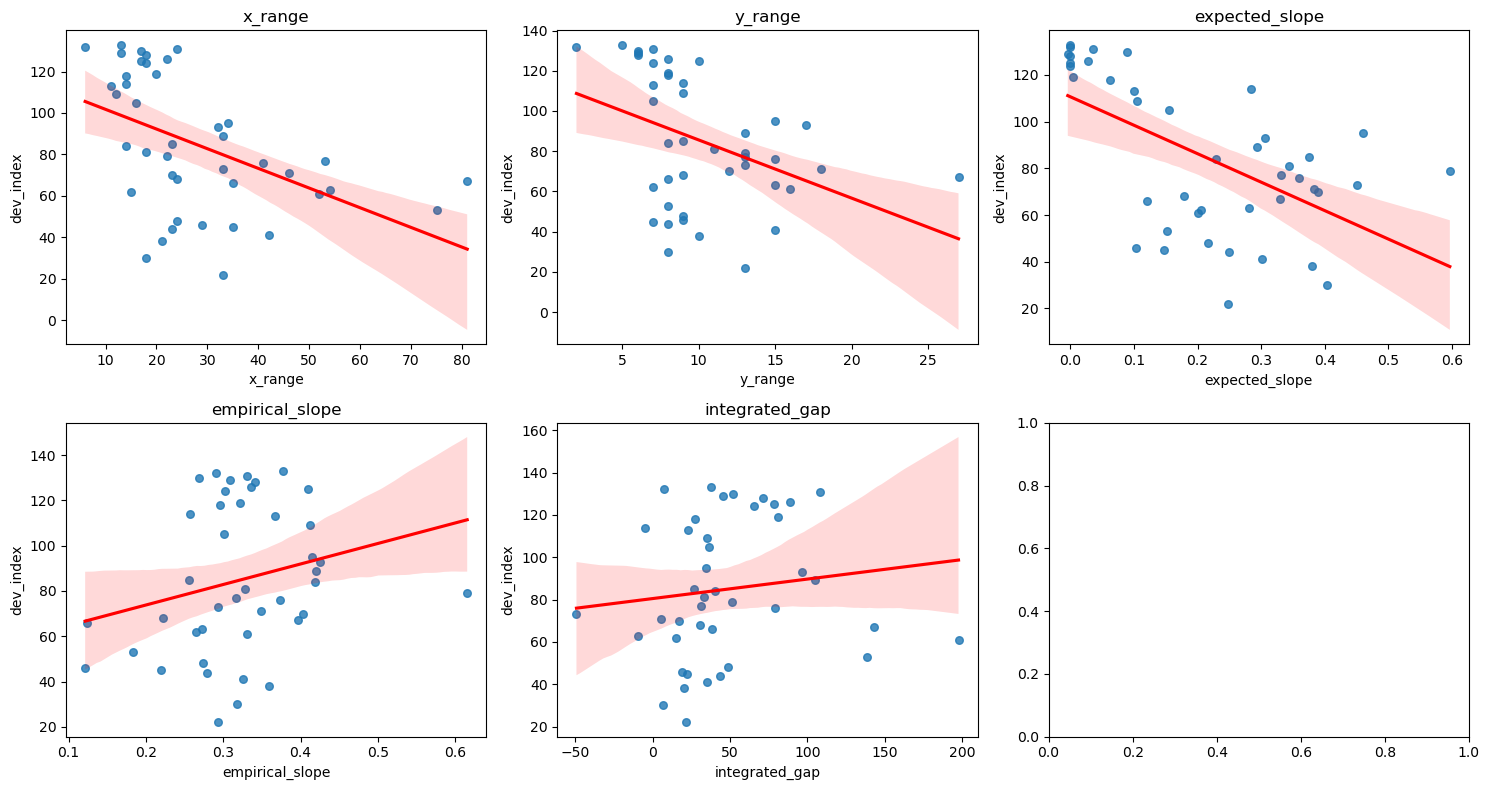

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "x_range",
    "y_range",
    "expected_slope",
    "empirical_slope",
    "integrated_gap"
]

n = len(features)
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))

for ax, f in zip(axes.flatten(), features):
    sns.regplot(data=df, x=f, y="dev_index", ax=ax, scatter_kws={"s":30}, line_kws={"color":"red"})
    ax.set_title(f)

plt.tight_layout()
plt.show()


In [15]:
print("min slope_ratio:", df["slope_ratio"].min())
print("max slope_ratio:", df["slope_ratio"].max())
print()

print(df["slope_ratio"].describe())


min slope_ratio: -354.60207310677146
max slope_ratio: 37740124.81260678

count    4.200000e+01
mean     2.400894e+06
std      8.814574e+06
min     -3.546021e+02
25%      9.541966e-01
50%      1.189690e+00
75%      1.922495e+00
max      3.774012e+07
Name: slope_ratio, dtype: float64
